# Prediction - Store Sales

# 1.0 Overview

### 1.1 Overview

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

reference: https://www.kaggle.com/competitions/rossmann-store-sales/data

### 1.1.2 CRISP - DS

CRoss-Industry Process - Data Science

- Development Cicle Method 
   - Do the same process many times to improve the prediction in each cicle.
   - In each end-to-end cicle have a version with the solution.
   - Velocity to delivery values.
   - Mapping all possibibles problems.
   

#### 1.1.2.1 CRISP Steps

1. Business questions - Try to solve problems with all areas and people.
2. Understand the Business - What's the poeple want? Normally the people give the solution, and we need to discover the "pain" of this person/business
3. Data Collect - From Databases, API, Files...
4. Data Clean - Keep a "stadard" data and remove dirty data, fillout NA's...
5. Data Exploration/Feature Engineering - What's the variable will impact the model(the result). Find the correlation between the fields.
6. Data Modeling - Prepare the data to put into the ML code (train and test, encoding, transform data, answer data...)
7. Apply ML 
8. Algoritimun Accuracy - Calculate the errors using ML's/Statistics (MAP, RME, MAPE, RMSE, ROCK, ACCURACY, TRUE TABLE...)

After the step 8º you and the team can see that the accuracy of the FIRST model will impact well the solution (normally not happen after the first cicle), we can put the MODEL in production, if not, start the other CICLE in STEP 2.

**IMPORTANT** you not back on the step 1 because the problem will be YOU, and we need to decide and change the steps 2º to 8º.

#### 1.1.2.2 Business Questions

What's the sales value of each store in the next 6 weeks?

#### 1.1.2.3 Understand the Business

- **What's the motivation to do this?** CFO (Chief Financial Officer) has requested the prediction of sales at the monthly meeting about the stores results.
- **What's the main cause of the problem?** Difficult to understand the value of investment to renovate each store.
- **Who is the stakeholder of the problem?** Director Finance (CFO) of Rossmann
- **What's the solution/product format that will be delivered?**
    - Granularity: Prediction sell per day and store on the next 42 days (6 weeks).
    - Problem type: Forecast sell .
    - Potencials Methods: Temporal series, regression with modifications.
    - Product/solution format: Check on the phone the total salles in each store on the final of the 6 weeks

# 2.0 IMPORTS

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt
import datetime

import inflection
import math

from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from IPython.core.display import HTML
from IPython.display import Image

### 2.1 Helper Functions

In [2]:
#Set my persnoal jupyter notebook
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
  # pd.options.display.max_columns = None
  # pd.options.display.max_rows = None
  #  pd.set_option( 'display.expand_frame_repr', False )

    sns.set()
    
jupyter_settings()



def cramer_v(x, y):
    cm = pd.crosstab( x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2.contigency( cm )[0]
    chi1corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt( (chi1corr/n) / (min( kcorr-1, rcorr-1)) )

### 2.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False )

# Merge the both raw data
# merge(reference_table, merged_table, type of merge, column key equal in both tables )
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

# 3.0 Data Clean

- **Why Data Description?**
    - **How challenger is the problem im working?**
    - **What's the duration of this problem?**
        - Years?
        - Months?
        - Days?
    - **What's the quantity of the data?**
        - I have the enought resourcing to work?
            - I need servers to process the data?
            - Clusters?
            - Spark?
            - Hadoop?
    - **What's the variable types (will help to decide the techniques to apply):**
        - % Numeric?
        - % Categories?
        - % Temporal?
    - **What's the NA(non-applicable/empty) data?**
        - NA's volume
        - What's the reazon of this NA's? 
            - I can do the job?
            - How I will reaplace the data?
            - I can replace or delete the data?
            - **details** sometimes the system isn't recording the data, the input is manually.
    - **Data summary:**
        - Describe stats.
        - Get the limits, minimum, maximun, STD, mean...
        
    

## 3.1 DATA DESCRIPTION

#### 3.1.1 Rename Columns

In [4]:
#Copy to keep the raw data.
df1 = df_raw.copy()

In [5]:
#Show the columns name
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old_names = df1.columns

#Create a function using the inflection library with undersocore method to puth _ between the name of the columns
snakecase = lambda x: inflection.underscore(x)

#Create a list with new columns name
cols_new_name = list(map(snakecase, cols_old_names))

#replace the old to new columns names
df1.columns = cols_new_name

#Show the new names
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

#### 3.1.2 Data Dimensions

In [7]:
#Total rows and columns
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


#### 3.1.3 Data Types

In [8]:
#Show the data type for each column
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
#Change the date object to datetime type
df1['date'] = pd.to_datetime( df1['date'] )

#### 3.1.4 Check NA's

In [10]:
#Check the NA's total has in each line
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

**important** We have three possibilities to management the NA's
  1. Discard the row that contain NA's (delete)
  2. Use the mean, median, or ML methods.
  3. Use the business questions to decide how we can replace.

##### 3.1.4.1 Fillout NA's

In [11]:
#CompetitionDistance - distance in meters to the nearest competitor store
#decision: Assuming two hypotheses, or the store doesn't have competition or the competitor store is very far.
#action: Fillout the NA's with a big distance to assuming these stores doesn't have a competition.
# df1['competition_distance'].max() = 75860.0

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )


#CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
#decision: Assuming these hypotheses, or the store doesn't open yet or the store opened before our store or we didn't record when the competitor store was open.
#action: Fillout the NA's with the same sale date of the same row.

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year']  = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)


#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
#decision: Assuming the store doesn't want to participate of the promo2 .
#action: Fillout the NA's with the same sale date of the same row.

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

#PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store#decision: Assuming the store doesn't want to participate of the promo2 .
#decision: Getting the month of the date sale and replace number to prefix month later fillna to 0 and cheching if this month is into the promo_interval, if yes set 1 else 0
#action: Fillout the NA's with the same sale date of the same row.

#Create the month_map
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#Fillna = 0, implace is not show the message/question
df1['promo_interval'].fillna(0, inplace=True)

#Create a column to see the months in "prefix" name
#get the DATE columns, transform in DATE(dt), get the month (month), and map(map) all data using the variable month_map
df1['month_map'] = df1['date'].dt.month.map( month_map )

#First condition: Split the promo_terval in comma, and check if df1['month_map'] is in on df1['promo_interval'], if yes 1 else 0
# 1 = The store is participating of the promo
# 0 = The store is not participating of the promo

#Second condition: If df1['promo_interval'] = 0 means that the store wasn't participating of the consecutive promotion
df1['ispromo'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)
 

In [12]:
df1.sample(5).T

,992301,890011,786252,939196,240263
store,737,1027,963,37,178
day_of_week,3,4,6,1,6
date,2013-01-23 00:00:00,2013-04-25 00:00:00,2013-07-27 00:00:00,2013-03-11 00:00:00,2014-12-27 00:00:00
sales,5642,12398,3678,3922,9509
customers,881,1656,344,517,905
open,1,1,1,1,1
promo,1,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,c,d


##### 3.1.4.5 Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
ispromo                                  int64
dtype: object

In [14]:
#Change types to INT
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( 'int64' )
df1['promo2_since_week']            = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year']            = df1['promo2_since_year'].astype( 'int64' )


##### 3.1.4.6 Descriptive Statistical

- **Central Tendency** One number to explain all = mean, median 
- **Dispersion** Check the spaces/dispersion between the central tendency of the other numbers (near or far of the mean/meadian) = std, min, max, range, skew, kurtosis 
    - Skew = Deformation on the normal distribuition
      - Left Skew = positive
      - right Skew = negative
    - Kurtosis = How the data is concentrate
        - Big Kurtosis = positive numbers
        - Small Kurtosis = negative numbers

In [15]:
#Separate the variables in two groups: numerics and categoric

num_attributes = df1.select_dtypes( include=['int64','float64'])
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'])


In [16]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,ispromo
803146,17,4,6028,819,1,0,0,50.0,12,2005,1,26,2010,1
86376,522,5,9485,769,1,0,0,7160.0,11,2012,1,9,2011,0
31006,902,6,3810,491,1,0,0,310.0,5,2015,1,40,2014,1
872959,700,5,0,0,0,0,0,830.0,5,2013,1,27,2013,0
378688,233,5,10471,1034,1,1,1,1890.0,8,2014,0,31,2014,0


In [17]:
cat_attributes.sample(5)


,state_holiday,store_type,assortment,promo_interval,month_map
968001,0,a,c,"Jan,Apr,Jul,Oct",Feb
673555,0,a,a,"Feb,May,Aug,Nov",Nov
268370,0,c,a,0,Nov
112478,0,a,c,"Jan,Apr,Jul,Oct",Apr
576967,0,a,a,0,Jan


###### 3.1.4.6.1 Numerical Attributes

In [18]:
#Central Tendency = mean, median 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion = std, min, max, range, skew, kurtosis 

d1 = pd.DataFrame (num_attributes.apply( np.std )).T
d2 = pd.DataFrame (num_attributes.apply( min )).T
d3 = pd.DataFrame (num_attributes.apply( max )).T
d4 = pd.DataFrame (num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame (num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame (num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'STD', 'Skew', 'Kurtosis' ]
m

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


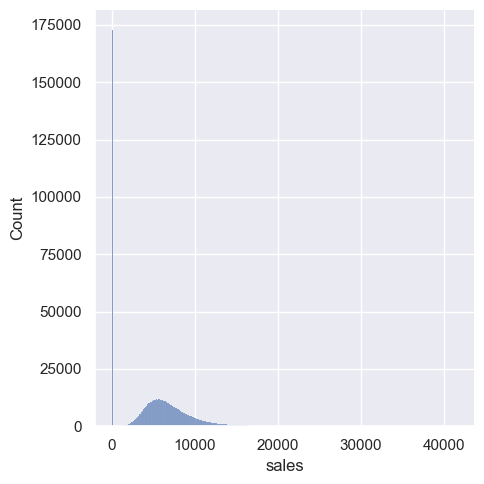

In [19]:
#Graph example
sns.displot(df1['sales'])

###### 3.1.4.6.2 Categorical Attributes

In [20]:
#Total unique values 
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

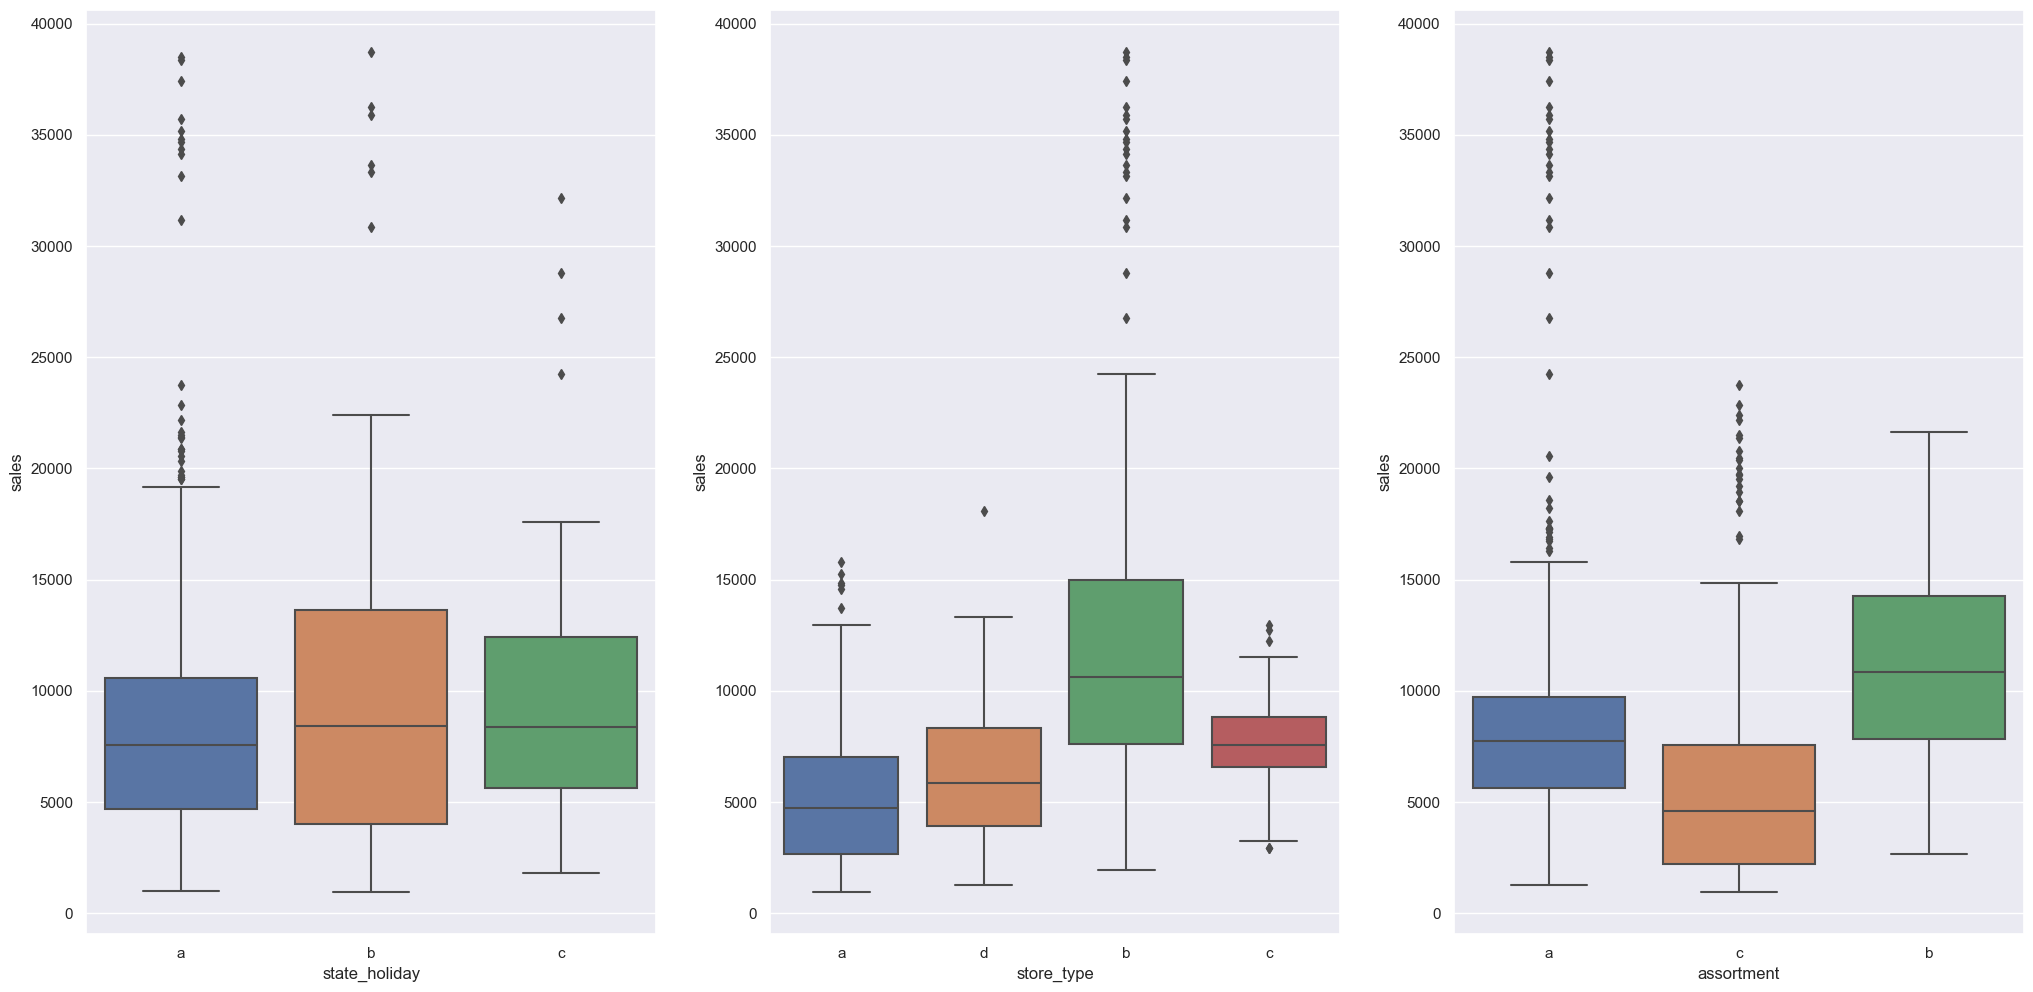

In [21]:
#Remove the closed stores and no sales
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

#1 rows, 3 columns, 1st position
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

#1 rows, 3 columns, 2nd position
plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

#1 rows, 3 columns, 3th position
plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)


##important##
#Outliers = 3x STD

# 4.0 Data Exploration

 - Habe available variables to study during the Data Analyse Exploration
 - Hyphotese Mental Map:
     - **OBJECTIVE** - Create hypotheses to dala validation or delete hypotheses to get the I N S I G H T S. 
     - **INSIGHTS** - can be generation in 2 forms:
         1. Surprise: When the data does not show explicit.
         2. Oppose the belief: When the people (CFO, CEO...) have 99% that's hypothese is true.
     - What's this? To see how complicated and deep we wanna go with the hypotheses. Don't forget that our project is a cycle project where we will review all steps in each cycle, and we don't need to lose a massive time in this step going very deep. This map will help to validate the hypotheses and which variables we need to create a feature engineering.
     - Three elements that compose the map:
         1.   Phenomenon -> What's the phenomenon I'm modeling? Sell, detect objects in an image, classification the image (i.e. Cat or Dog), person cluster (create personas)...
         2. Agents -> Which agents act on into the phenomenon (everything thats impact the phenomenon? **Clients** act on sell, **store** act on selling...
         3. Attributes -> Describe the agents. **Clients** can be descriple with age, salary, education, frequency to go at the store...

## 4.1 Hypothese Mental Map

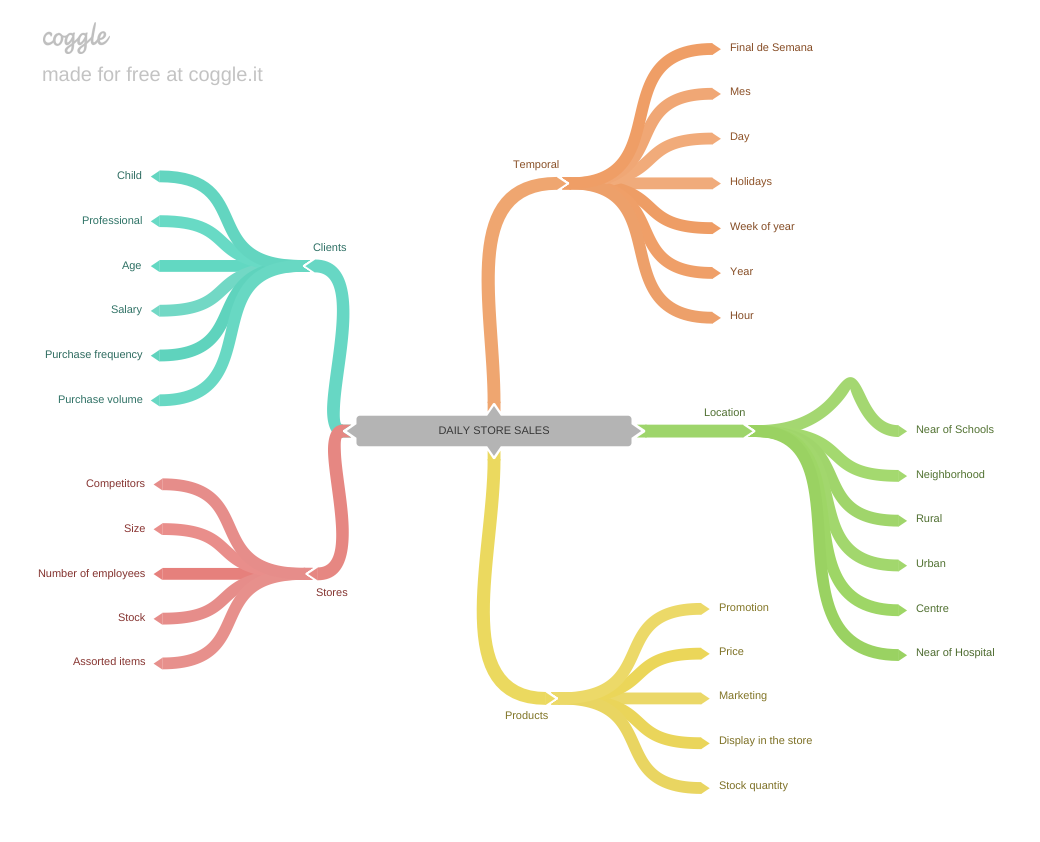

In [22]:
Image( '../assets/DAILY_STORE_SALES.png' )

 - **Hypotheses**, are bets about anything you have in your mind, examples:
     1. BIG stores should sell MORE.
     2. Stores with more ASSORTMENT should sell MORE.
     3. Stores with more nearby COMPETITORS should sell LESS
     
 These bets will be validate with our DATA.
 
 **important** The hypotheses are bets and are not cause and effect relations and then try to find the correlation between the hypothesis/bets and data.

## 4.2 Hypothesis Creation

### 4.2.1 Stores Hypothese 

**1.** Stores with the highest number of employees should sell more.

**2.** Stores with the highest stock should sell more.

**3.** Stores with the highest size should sell more.

**4.** Stores with the bigger assortment should sell more.

**5.** Stores with the neaby competitor should sell less.

**6.** Stores with the competitor for more time should sell more.

### 4.2.2 Product Hypothese 

**1.** Stores that investing in Marketing should sell more.

**2.** Stores that display more products in shop windows should sell more.

**3.** Stores that have the lowest price should sell more.

**4.** Stores that have promotion with big discounts should sell more.

**5.** Stores that have activated promotion for more time should sell more.

**6.** Stores that have promotion for more time should sell more.

**7.** Stores that have more consective promotions should sell more.

### 4.2.3 Temporal Hypothese 

**1.** Stores that open on the Christmass should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more o the second half.

**4.** Stores should sell more after the 10th day of the month.

**5.** Stores should sell less on the weekends.

**6.** Stores should sell less on the school holidays.

### 4.2.4 Prioritize Hypothesis 

**How to prioritize hypothesis:**
Do you have the DATA? if yes, select the hypothesis that you can answer with the data.

**1.** Stores with the bigger assortment should sell more.

**2.** Stores with the neaby competitor should sell less.

**3.** Stores with the competitor for more time should sell more.

**4.** Stores that have activated promotion for more time should sell more.

**5.** Stores that have promotion for more time should sell more.

**6.** Stores that have more consective promotions should sell more.

**7.** Stores that open on the Christmass should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more o the second half.

**10.** Stores should sell more after the 10th day of the month.

**11.** Stores should sell less on the weekends.

**12.** Stores should sell less on the school holidays.


## 4.3 Feature Engineering

In [23]:
df2 = df1.copy()

In [24]:
#day
df2['day'] = df2['date'].dt.day

#Year
df2['year'] = df2['date'].dt.isocalendar().year

#month
df2['month'] = df2['date'].dt.month

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


#competition_since
#Merge the competition_open_since_month and competition_open_since_year
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'] , day=1 ), axis=1 )
# Divide per 30 days to keep the month type
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days ).astype( 'int64' )


#promo_since
#Merge the promo2_since_week and promo2_since_year
# TRICK #
#First, concatenate and trandform in string = 2023-31
df2['promo_since'] = df2['promo2_since_year'].astype( str )+ '-' + df2['promo2_since_week'].astype( str )
# Deduce 1 day, put in the format 2023-31- and remove 7 days.
#Strptime python is used to convert string to datetime object
#https://www.nbshare.io/notebook/510557327/Strftime-and-Strptime-In-Python/
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] -df2['promo_since'] )/7 ).apply(lambda x: x.days).astype( 'int64' )

#Assortment
#a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'else 'extended')

#state_holiday
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## 4.4 Filter Variables

In [25]:
df3 = df2.copy()

**IMPORTANT** Filter variable will restric the features according with our business before to select the variables to put on the ML model. Sometimes, a feature will have a big impact in the model but we don't have access before to get the prediction, just later.

example:

During the data exploration, you saw that the discount feature has a big impact on sales, but you have the business team doesn't have the percentage of the discount before, just when the products are selling. In this case, the discount feature will be excluded from our model.

In [26]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


### 4.4.1 Row Variables Filter 

In [27]:
#Exclude if the store is close = 0 and sales need be greather then 0, because if the store is closed the sales will be zero.
df3 = df3[ (df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

### 4.4.2 Columns Variables Filter 

In [28]:
#Need to create other study to predict the total of customers in the next weeks. We can do this on the cicle 2, per example.
#After filter the column open we can drop.
#Delete the aux columns on the steps before
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1)

In [29]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


## 4.5 Data Analysis Exploration

In [30]:
df4 = df3.copy()

**IMPORTANT**

1. Witch variable will impact the phenomenon?

2. What's the force of this impact?

- Get attention in three points
    - **1.** Gain experience with Business Team
    - **2.** Validate hyphoteses on the step 4.1 and generate INSIGHES
        - 2.1 Surprises insights
        - 2.2 Shock a person grace
    - **3.** See the most important variables to the model.
    
 
3. We will do three analysis
     - 3.1 Univariate Analisis = Where we analyse one feature based in your self (MIN, MAX, Distribuition, Range...)
     - 3.2 Bivariate Analisis = How this variable will impact the answer variable? (Correlation, Hypotheses variable,...)
     - 3.3 Multivariable Analisis = How the variables related? 

### 4.5.1 Univariate Analisis

#### 4.5.1.1 Response Variable

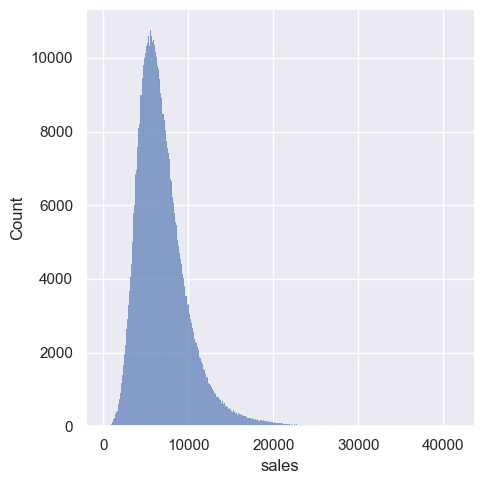

In [31]:
#Our variable answer is the SALES column.
#`distplot` is a deprecated function and will be removed in seaborn v0.14.0.
#sns.distplot(df4['sales'])

sns.displot(df4['sales'])

#analysis:
# format = Bell, positive Kurtosis (left side) but not in the center = normal distribuition.
# For ML algorithms, variables must be independent and distributed to the performance get better.

#### 4.5.1.2 Numerical Variable

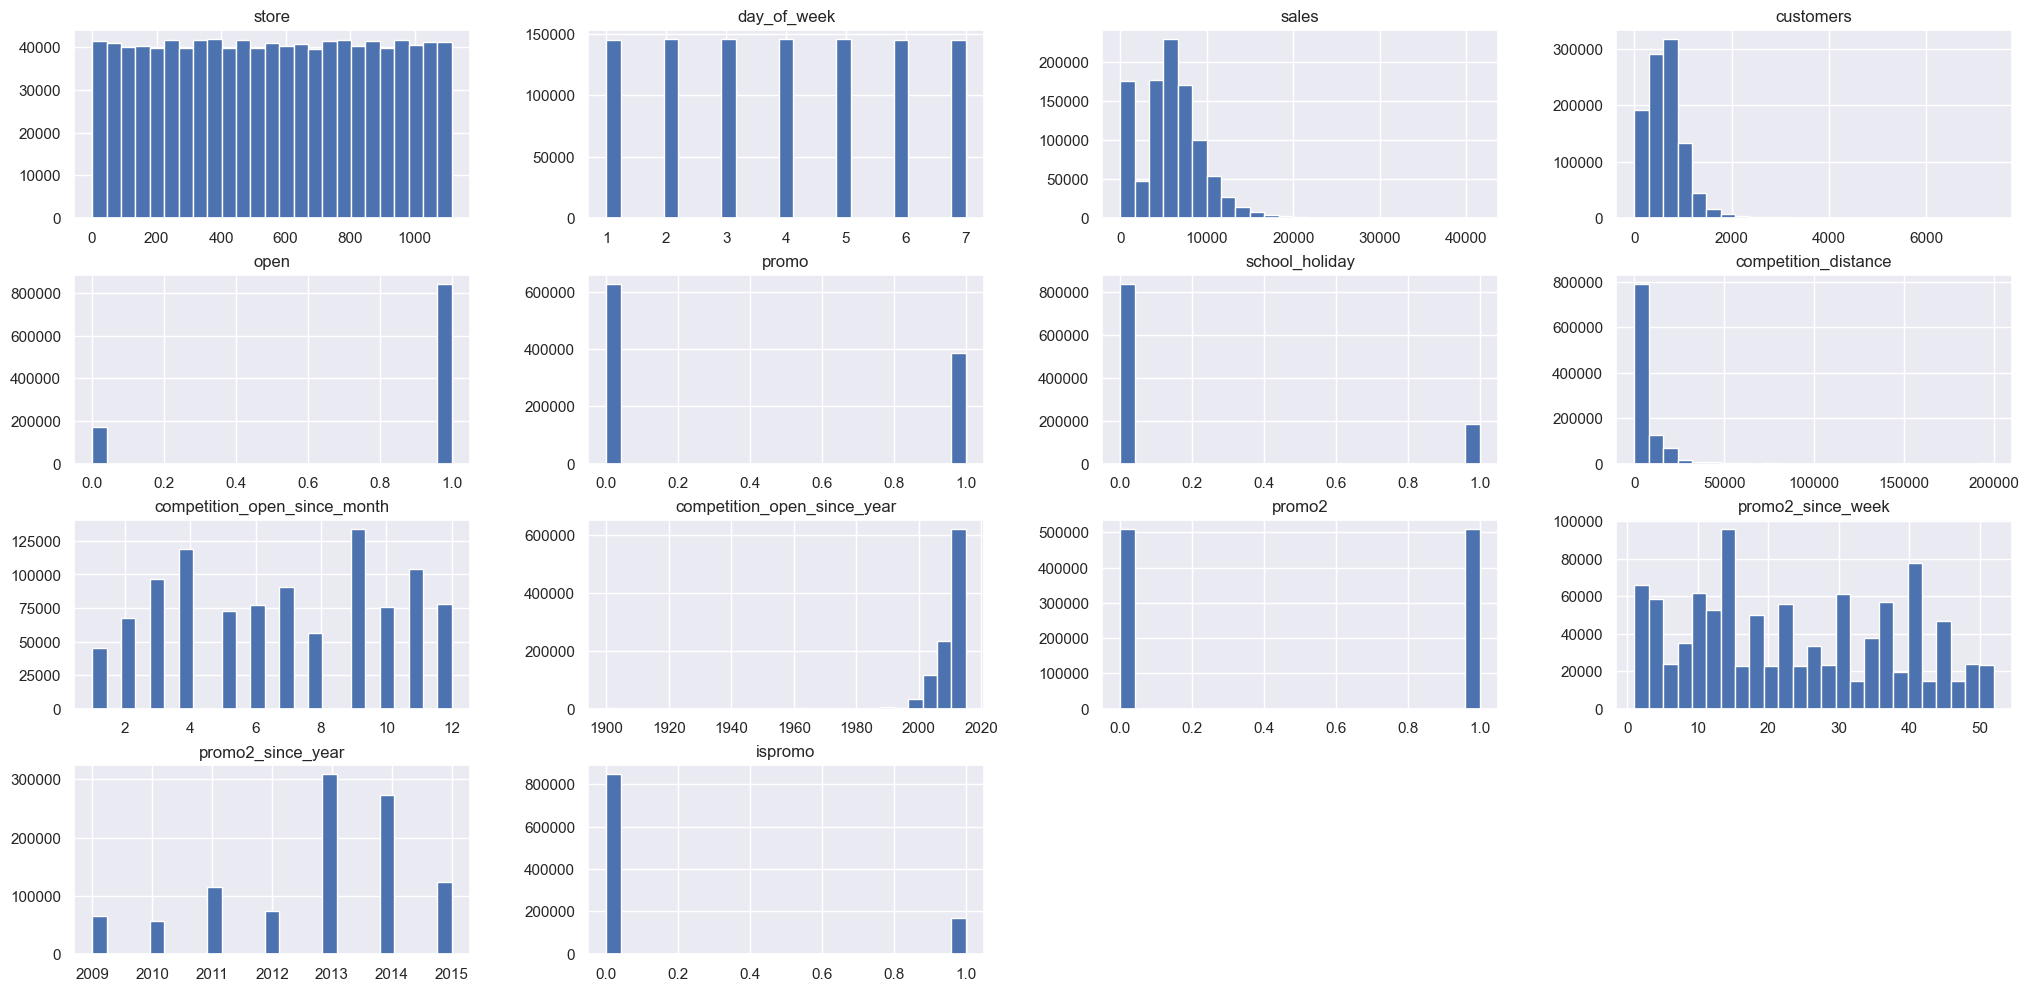

In [32]:
#See all cause and effect betweem the features abut the answer feature
# We can get some insights in this point 
# We can see some features will not impact our model

num_attributes.hist( bins=25 );


#### 4.5.1.1 Categorical Variable

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

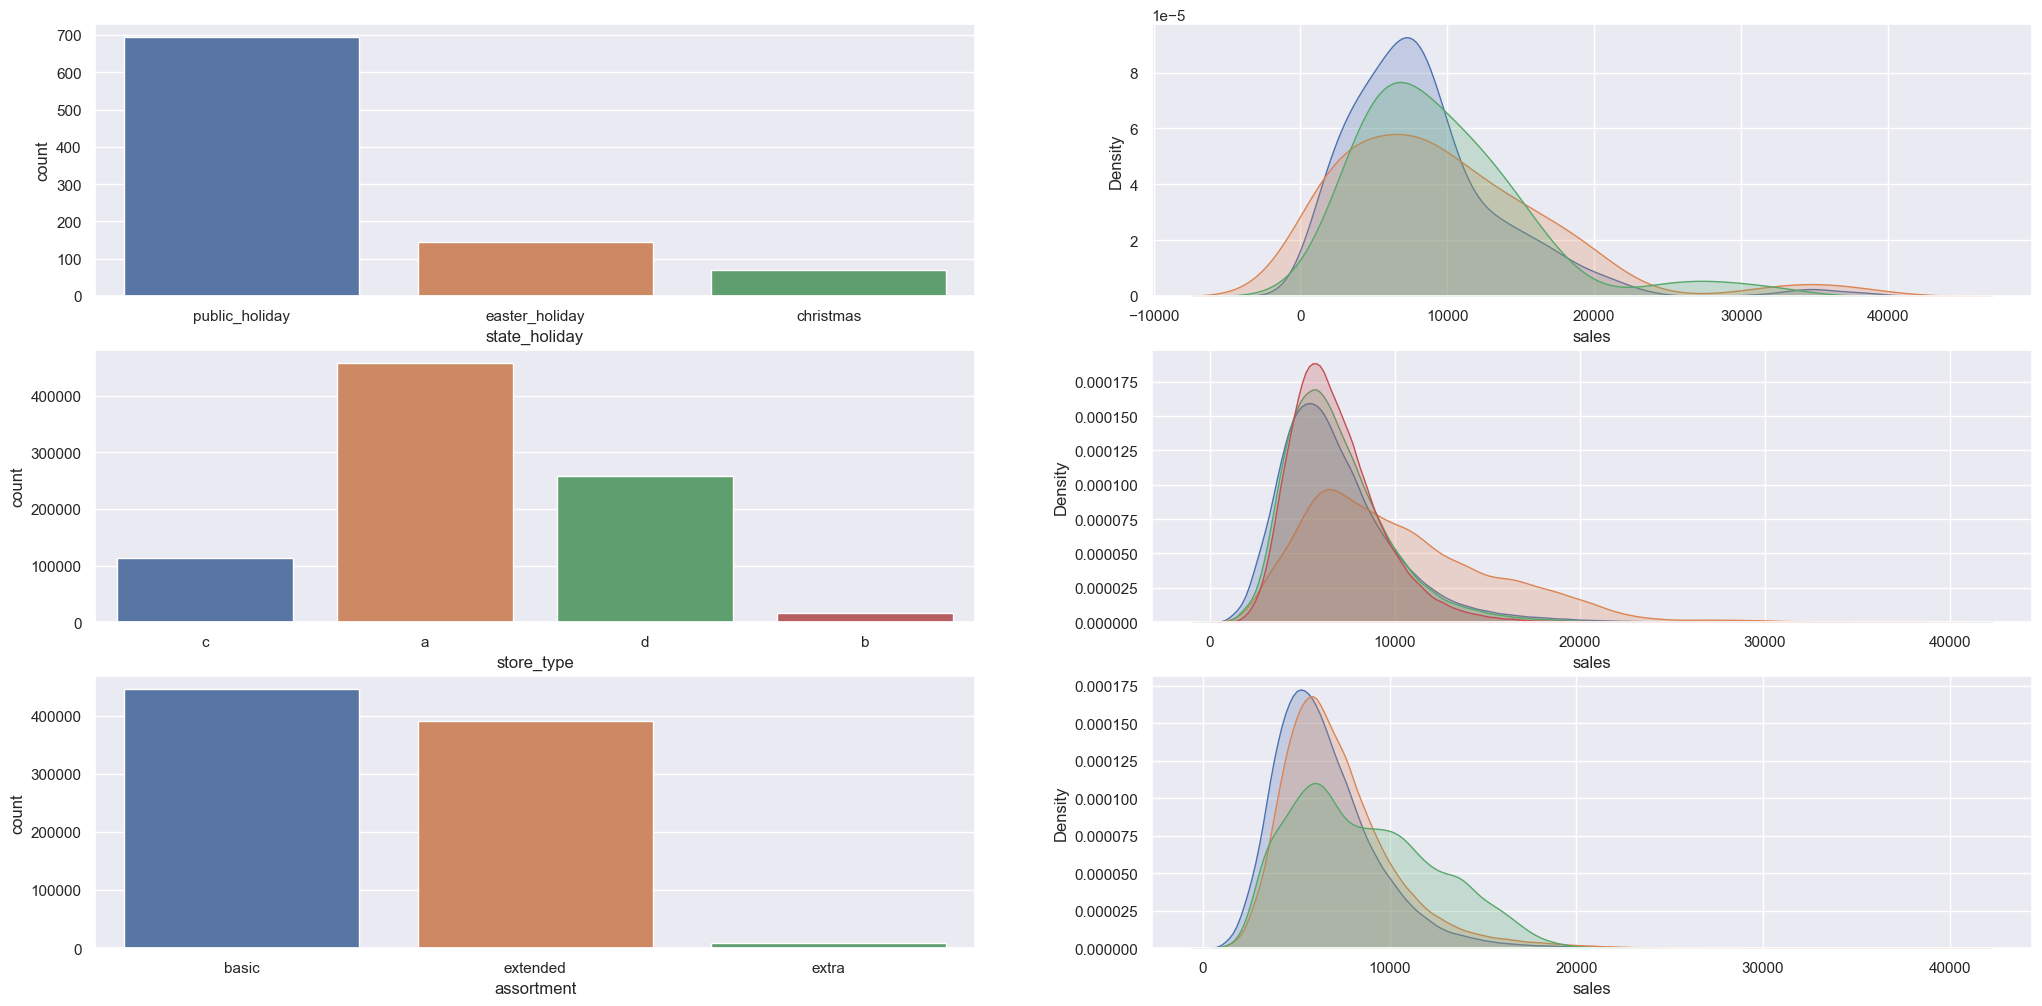

In [34]:
#https://seaborn.pydata.org/generated/seaborn.countplot.html
#suplot(rows, columns, position)

#state_holiday
plt.subplot( 3, 2, 1 ) 
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

#store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x=df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

#assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x=df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

### 4.5.2 Bivariate Analisis

#### H1. Stores with the bigger assortment should sell more.

<Axes: xlabel='year_week'>

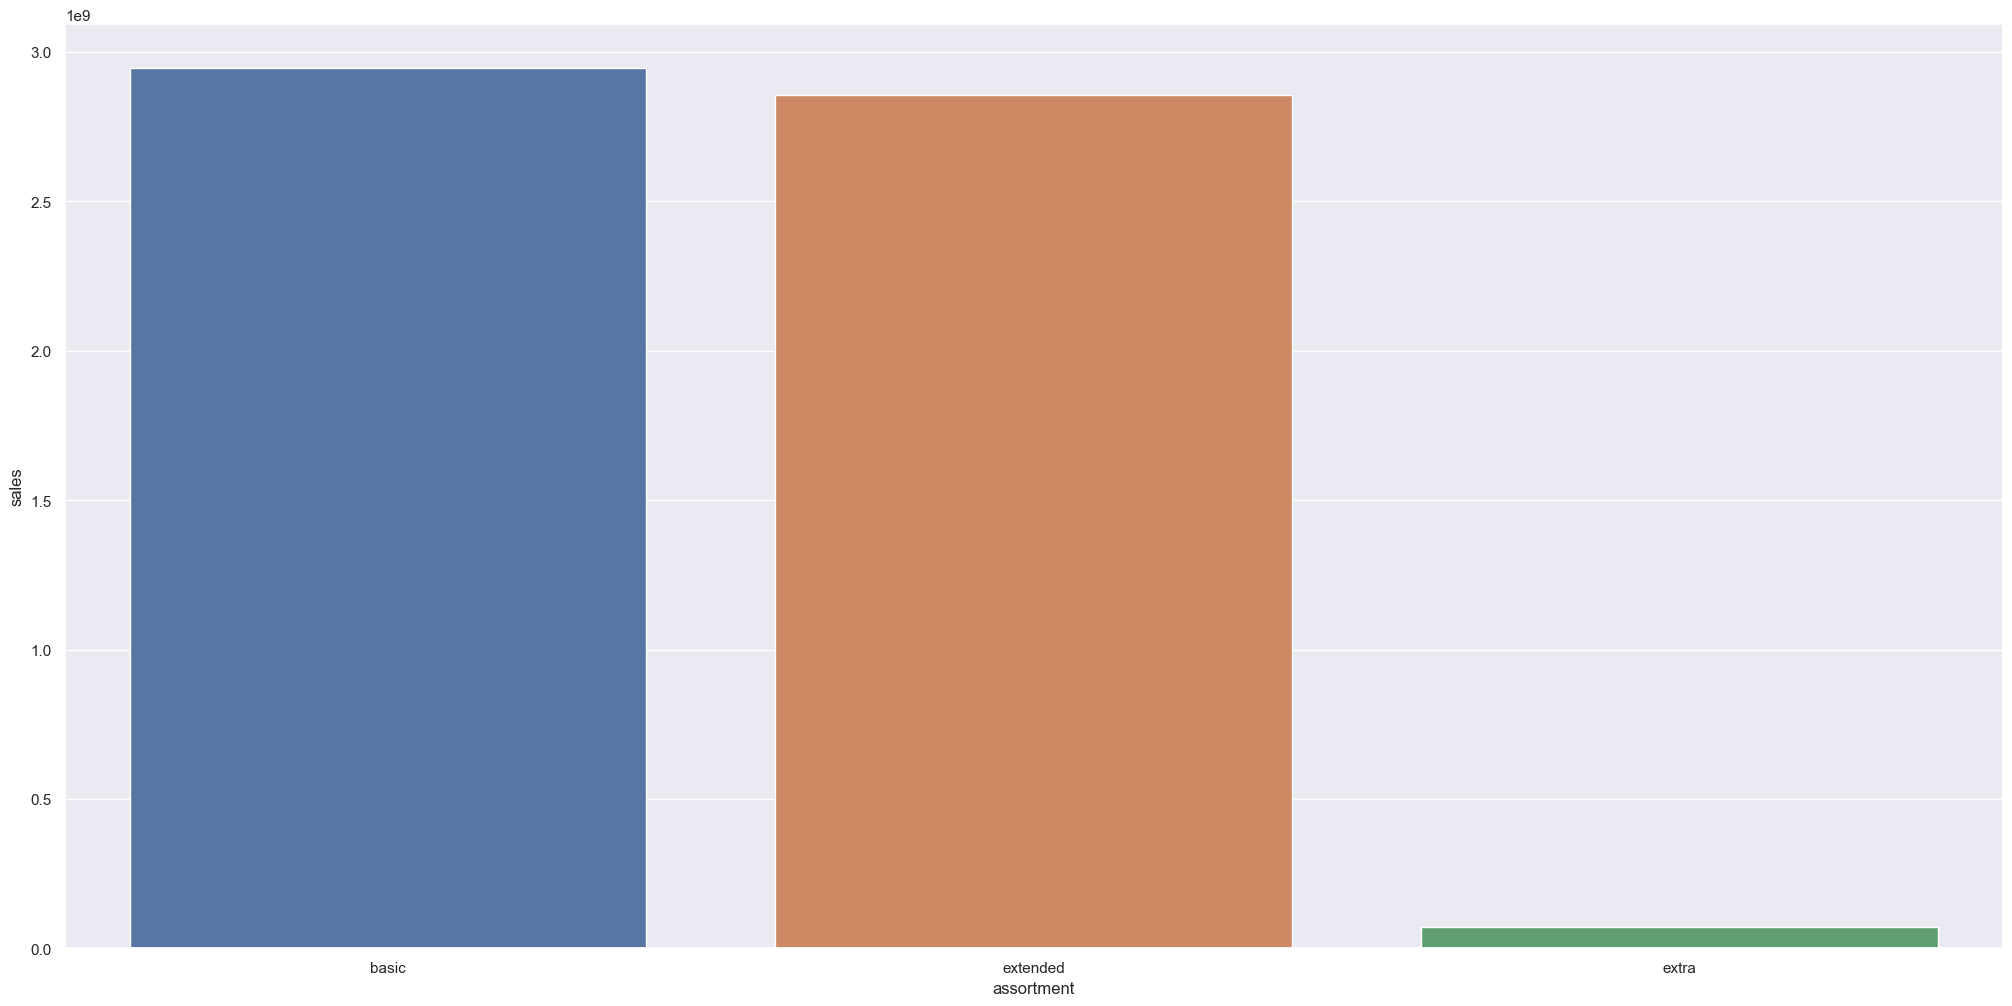

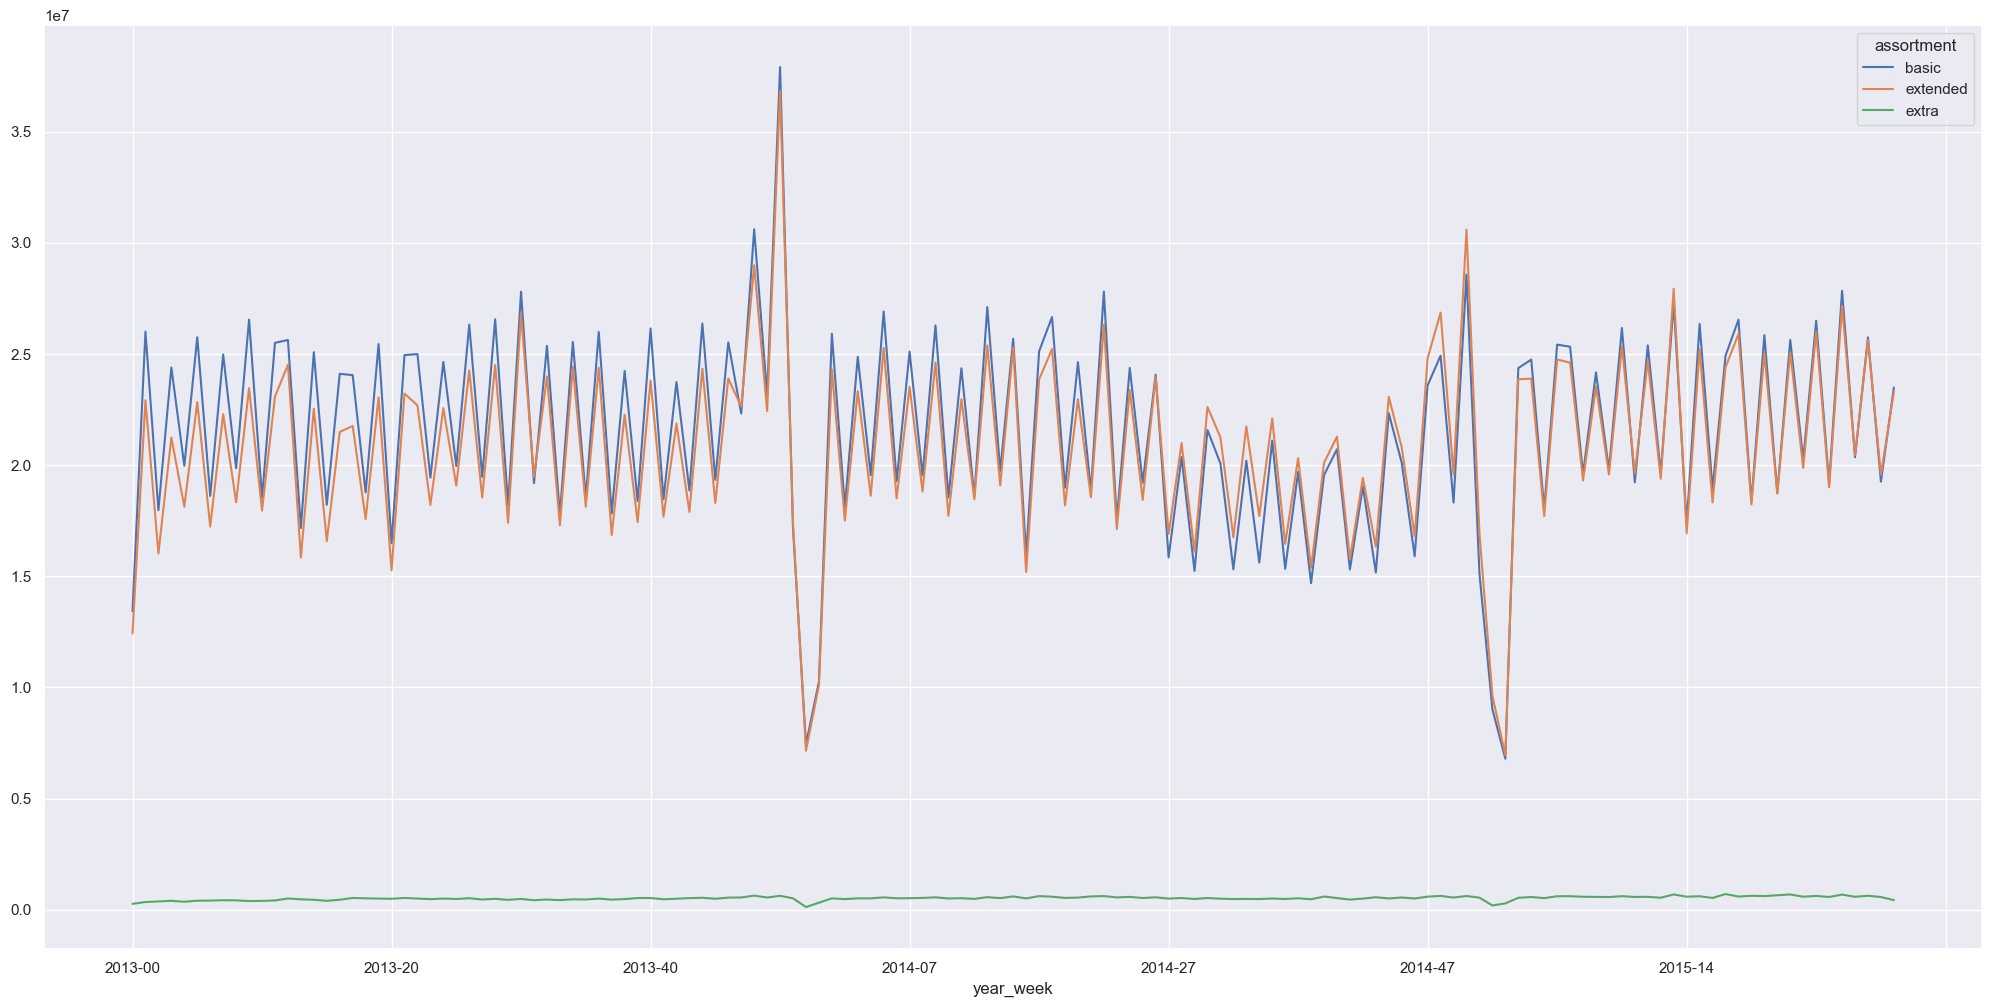

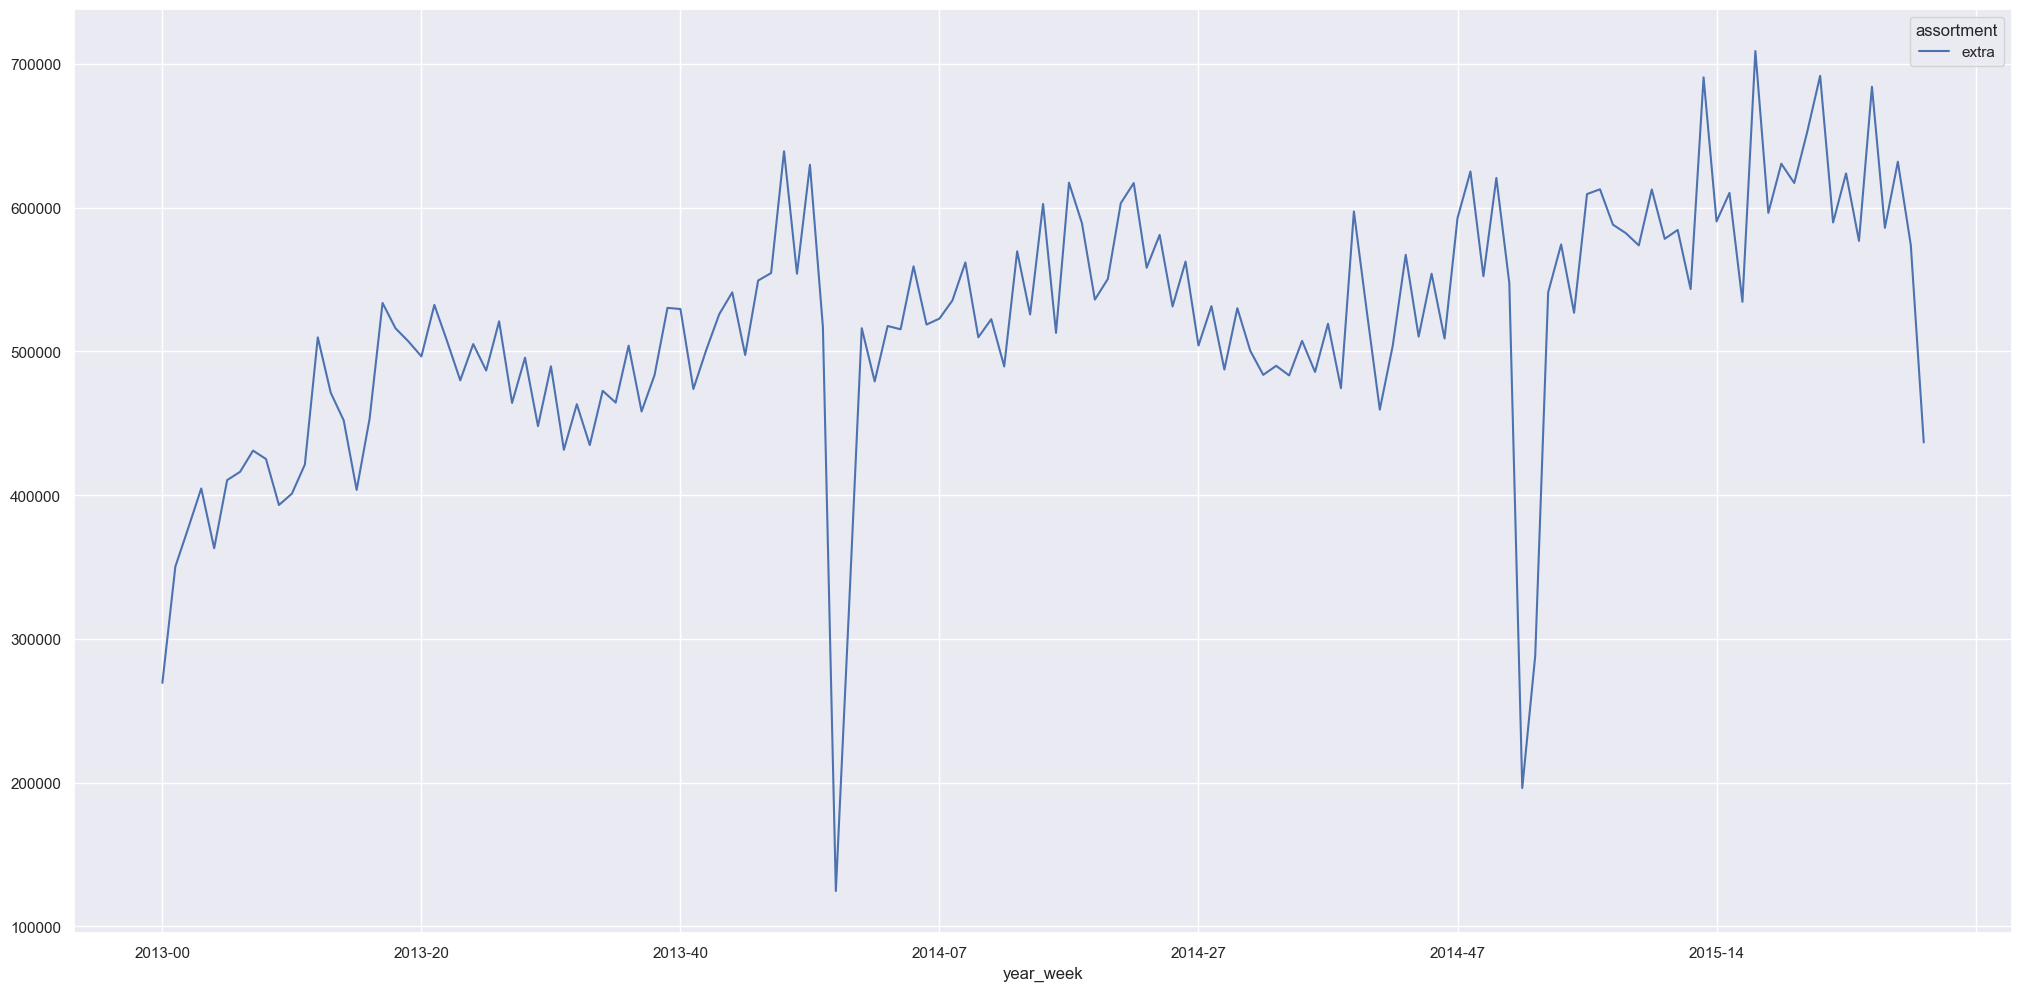

In [35]:
#FALSE
#Filter the dataframe as assortment and sales, group by assorment and plot the graph to analyse.
#Analysis: We can assume (because we don't have the description about the types of assortment) that this hyphotese is not true, because, extra assortment didn't sell more than others.
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

#Group by per year-week
#Analysis: We can see that basic and extended assortments have the same behaviour because the quantity of the data don't have a big difference.
aux2 = df4[['year_week','assortment','sales']].groupby( ['assortment','year_week'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

#*************************IMPORTANT*************************
#Checking the EXTRA assortment
#Analysis: After filter the data as EXTRA assortment, we see that the extra assortment behaviour is different when this feature is together.
aux3 = aux2[aux2['assortment']  == 'extra' ]
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()


#### H2. Stores with the neaby competitor should sell less.

<Axes: >

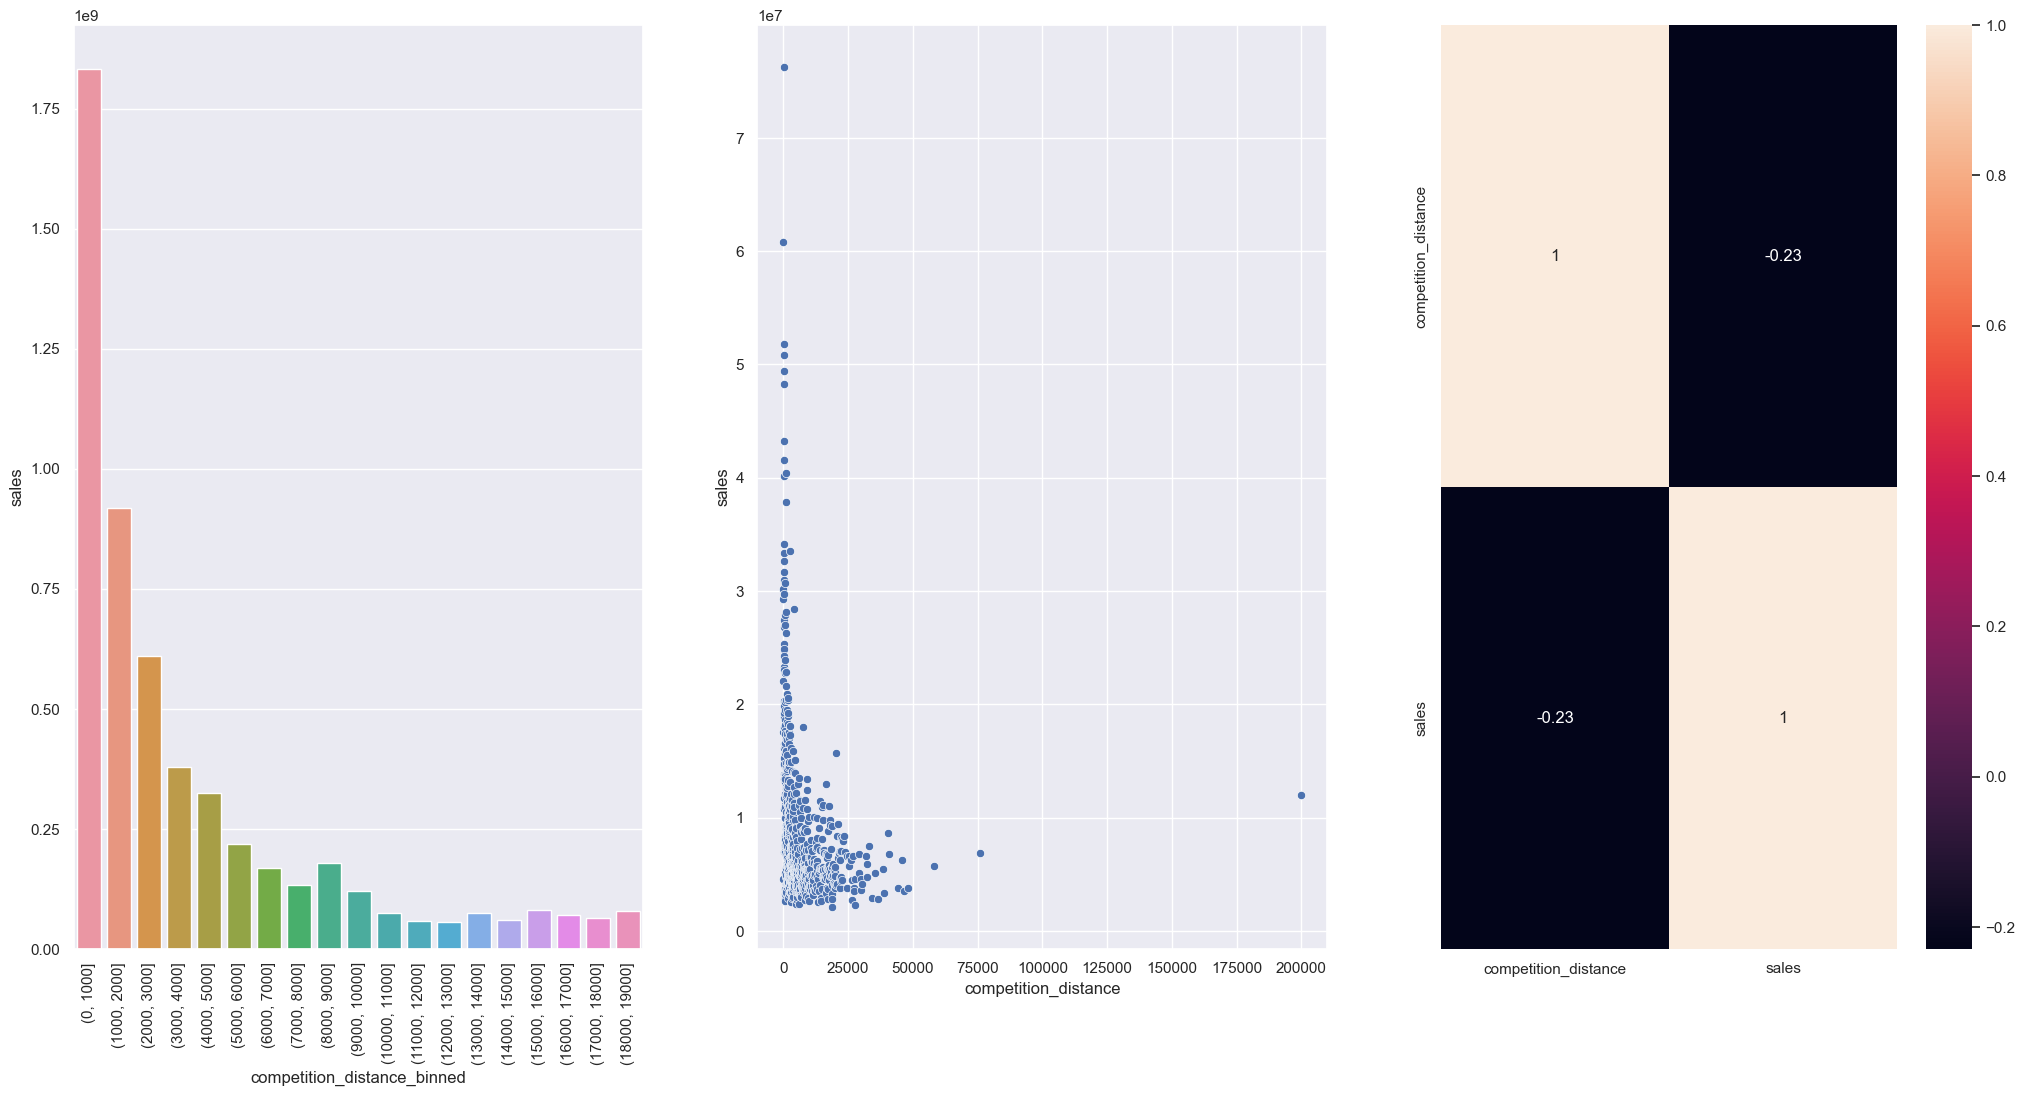

In [36]:
#FALSE
#Filter the dataframe as competition_distance and sales, group by competition_distance 
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#Create the bins = increase 1000 to 1000
bins = list( np.arange( 0, 20000, 1000 ) )

#Cut the data in bins, using PD.CUT and putting into a new variable
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

#grid
plt.subplot (1, 3, 1)

#plot
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 )

#Filter the dataframe as competition_distance and sales, group by competition_distance 
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#grid
plt.subplot (1, 3, 2)
#Scatter plot - dots
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);


#grid
plt.subplot (1, 3, 3)
#Correlation map
sns.heatmap(aux1.corr( method='pearson' ), annot=True)


#### H3. Stores with the competitor for more time should sell more.

<Axes: >

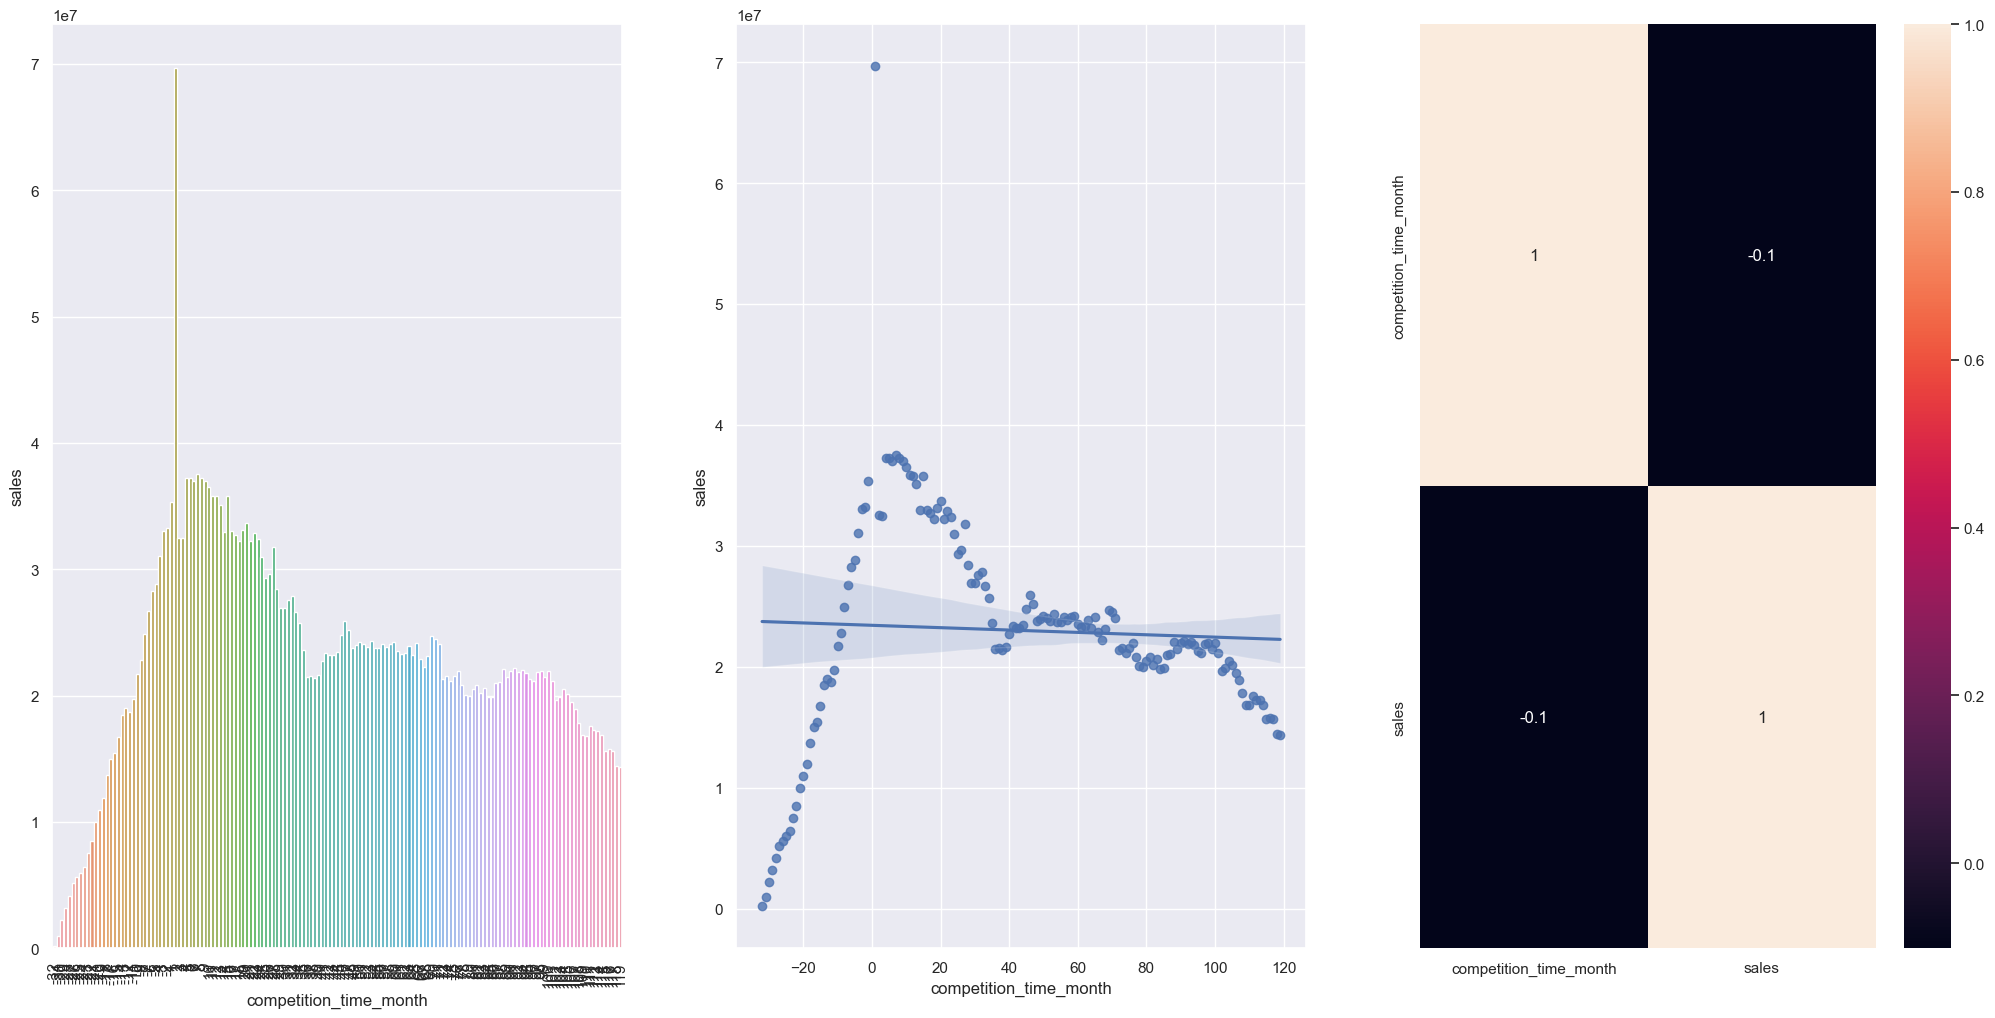

In [37]:
#TRUE
#Analysis: The more recent the competition (when the competitor open) more sales.


aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[ ( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]
plt.subplot (1, 3, 1)
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot (1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method='pearson' ), annot=True)

#### H4. Stores that have activated promotion for more time should sell more.


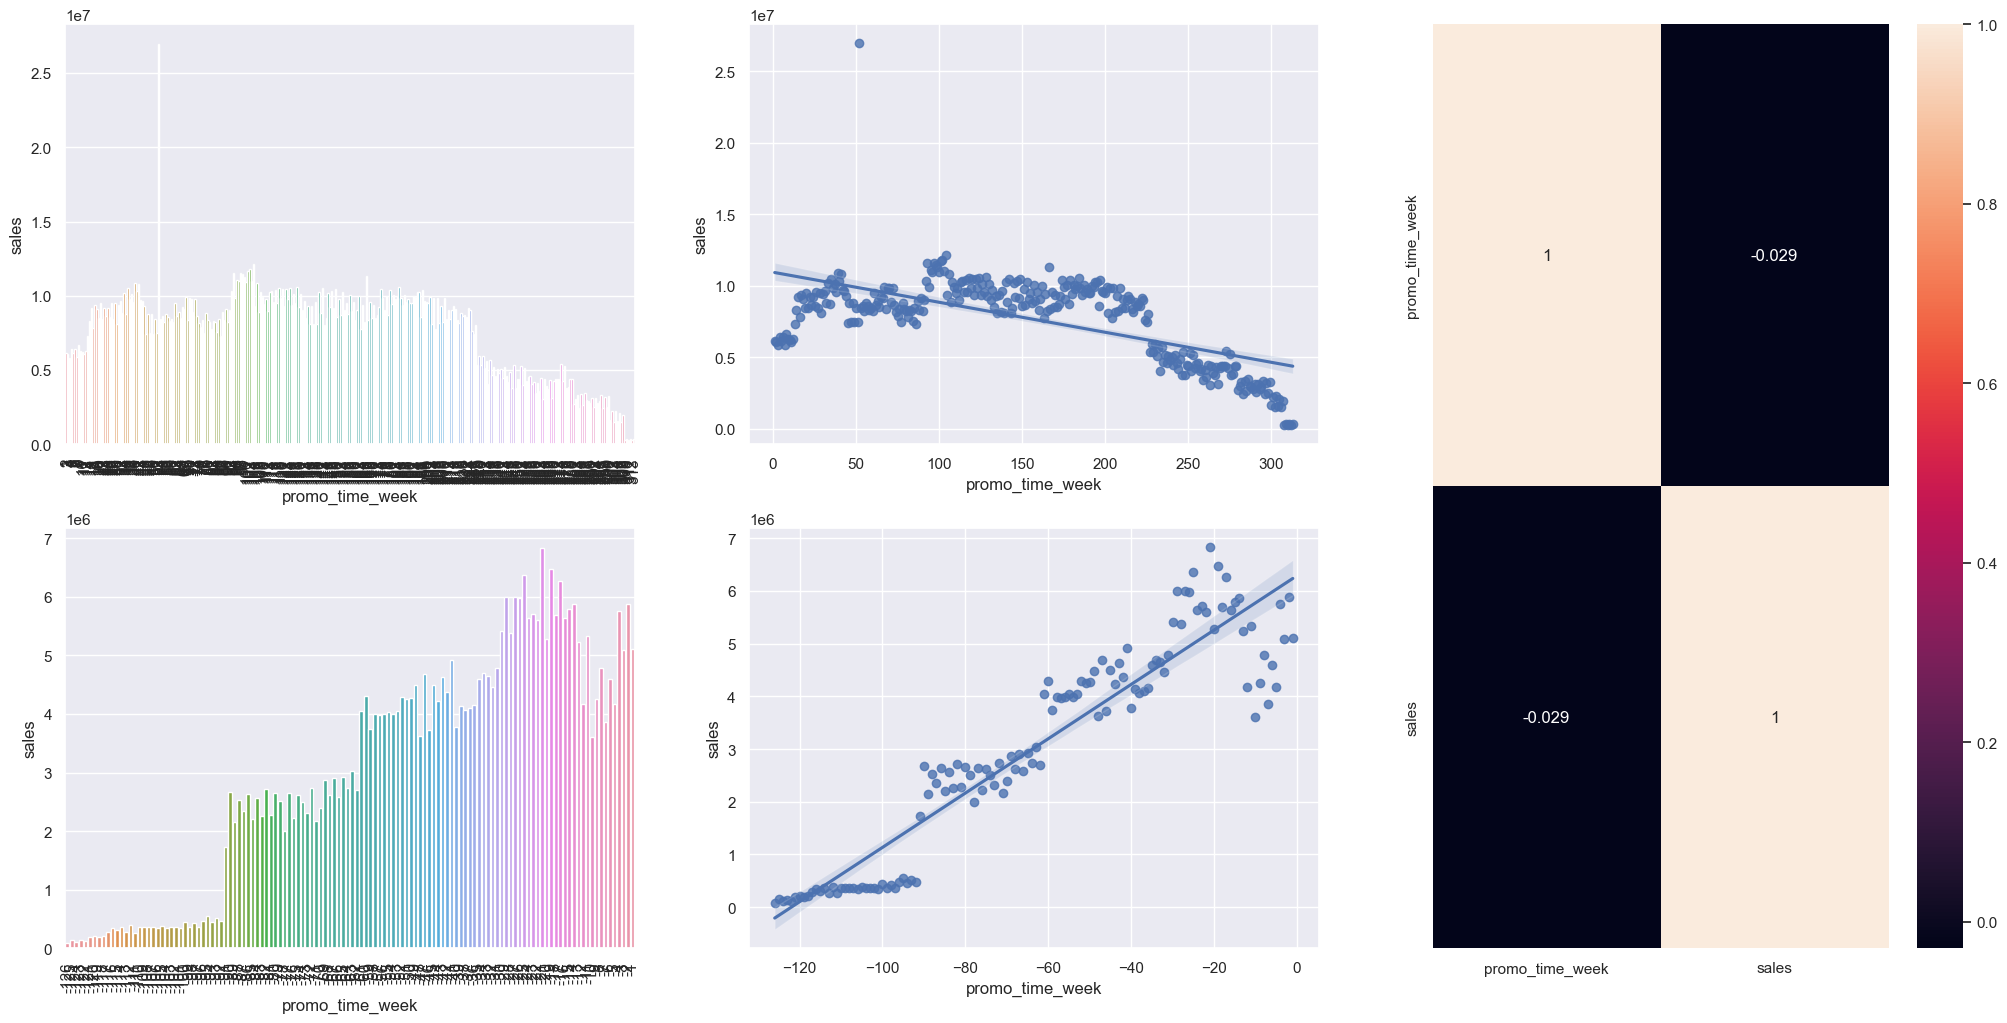

In [38]:
#FALSE

#Analysis: The column promo_time_week can be POSITIVE or NEGATIVE.
# Positive: When sales took place during the EXTENDED PROMOTION period.
# Negative:  When sales took place before the EXTENDED SALE period.
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = plt.GridSpec( 2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] #POSITIVE(extended period)
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] #NEGATIVE(normal period)
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### H<s> 5. Stores that have promotion for more time should sell more. </s> Next CRISP cicle

#### H6. Stores that have more consecutive promotions should sell more

In [39]:
#
##See the total sales per promotion
#Analysis: We can see that the store with promo sold more then other option
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


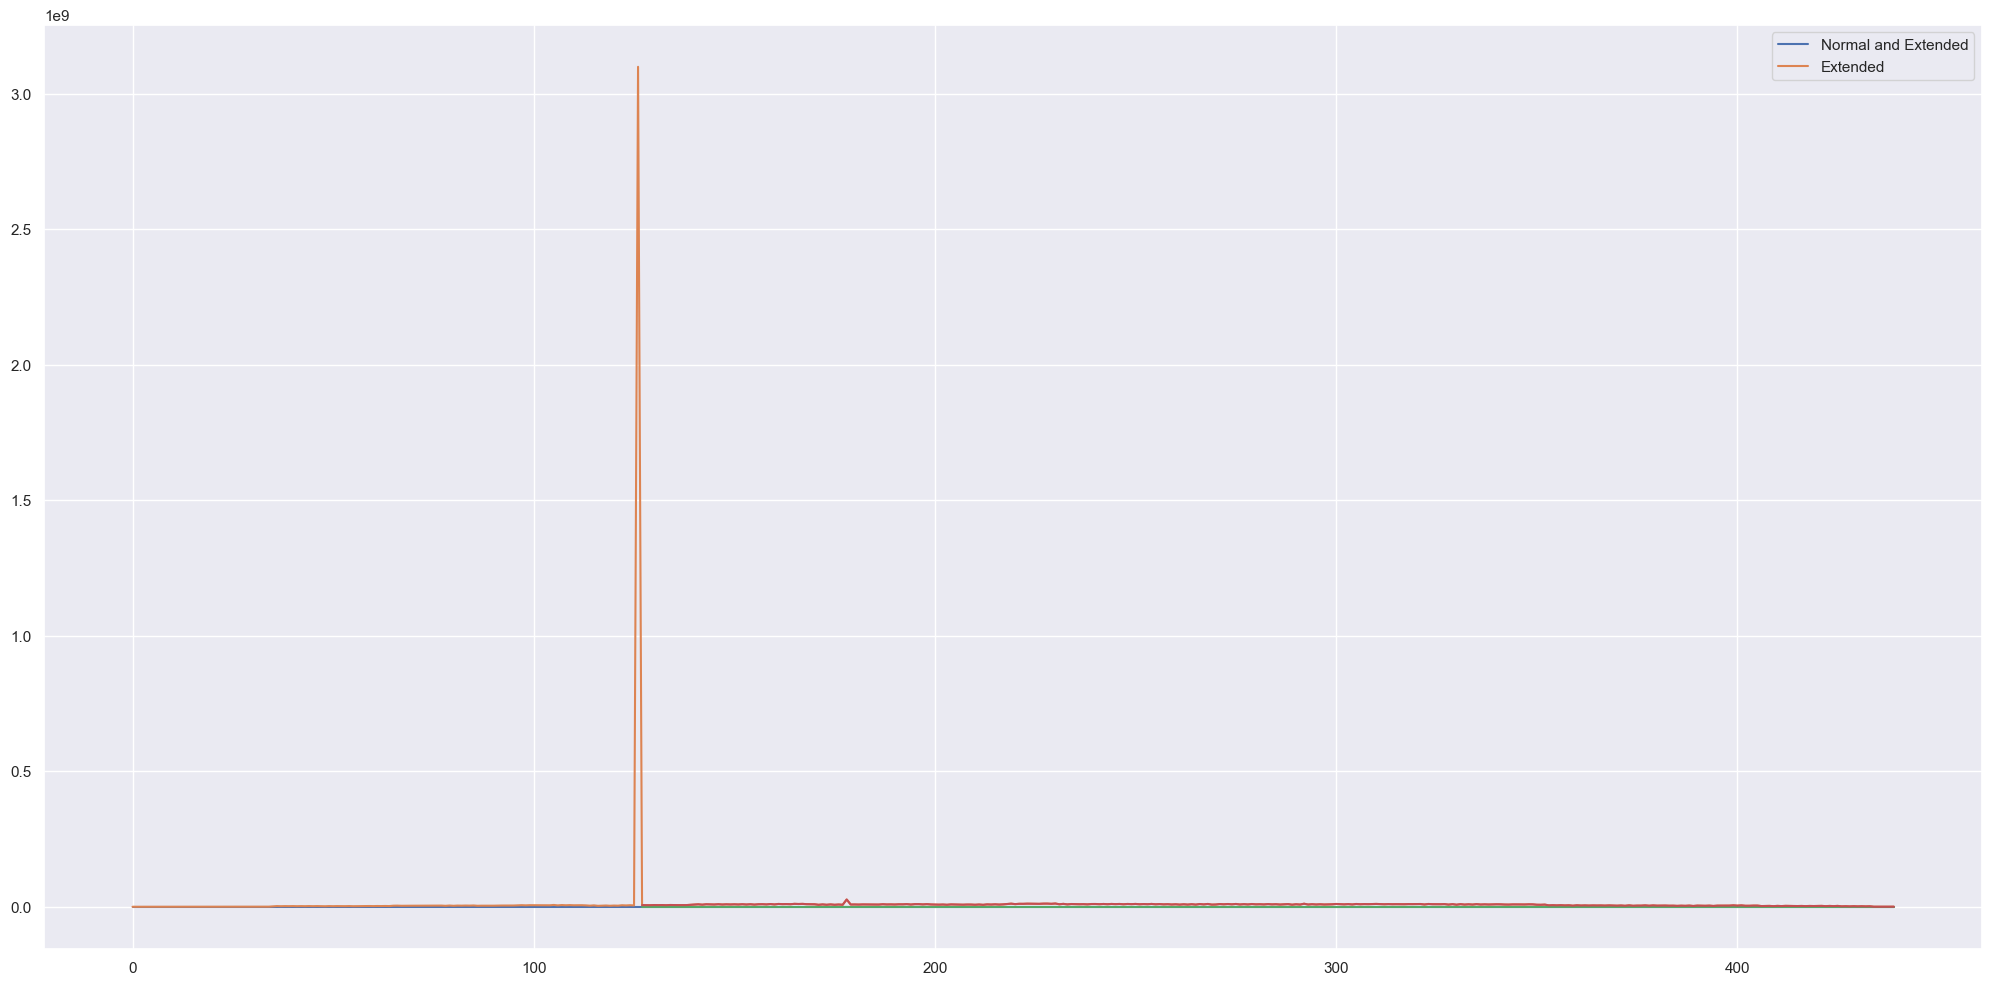

In [40]:
#All stores with promotion and promotion exteded
df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

#All stores with promotion and without promotion exteded
df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Normal and Extended', 'Extended'] )


#### H**7.** Stores that open on the Christmass should sell more.

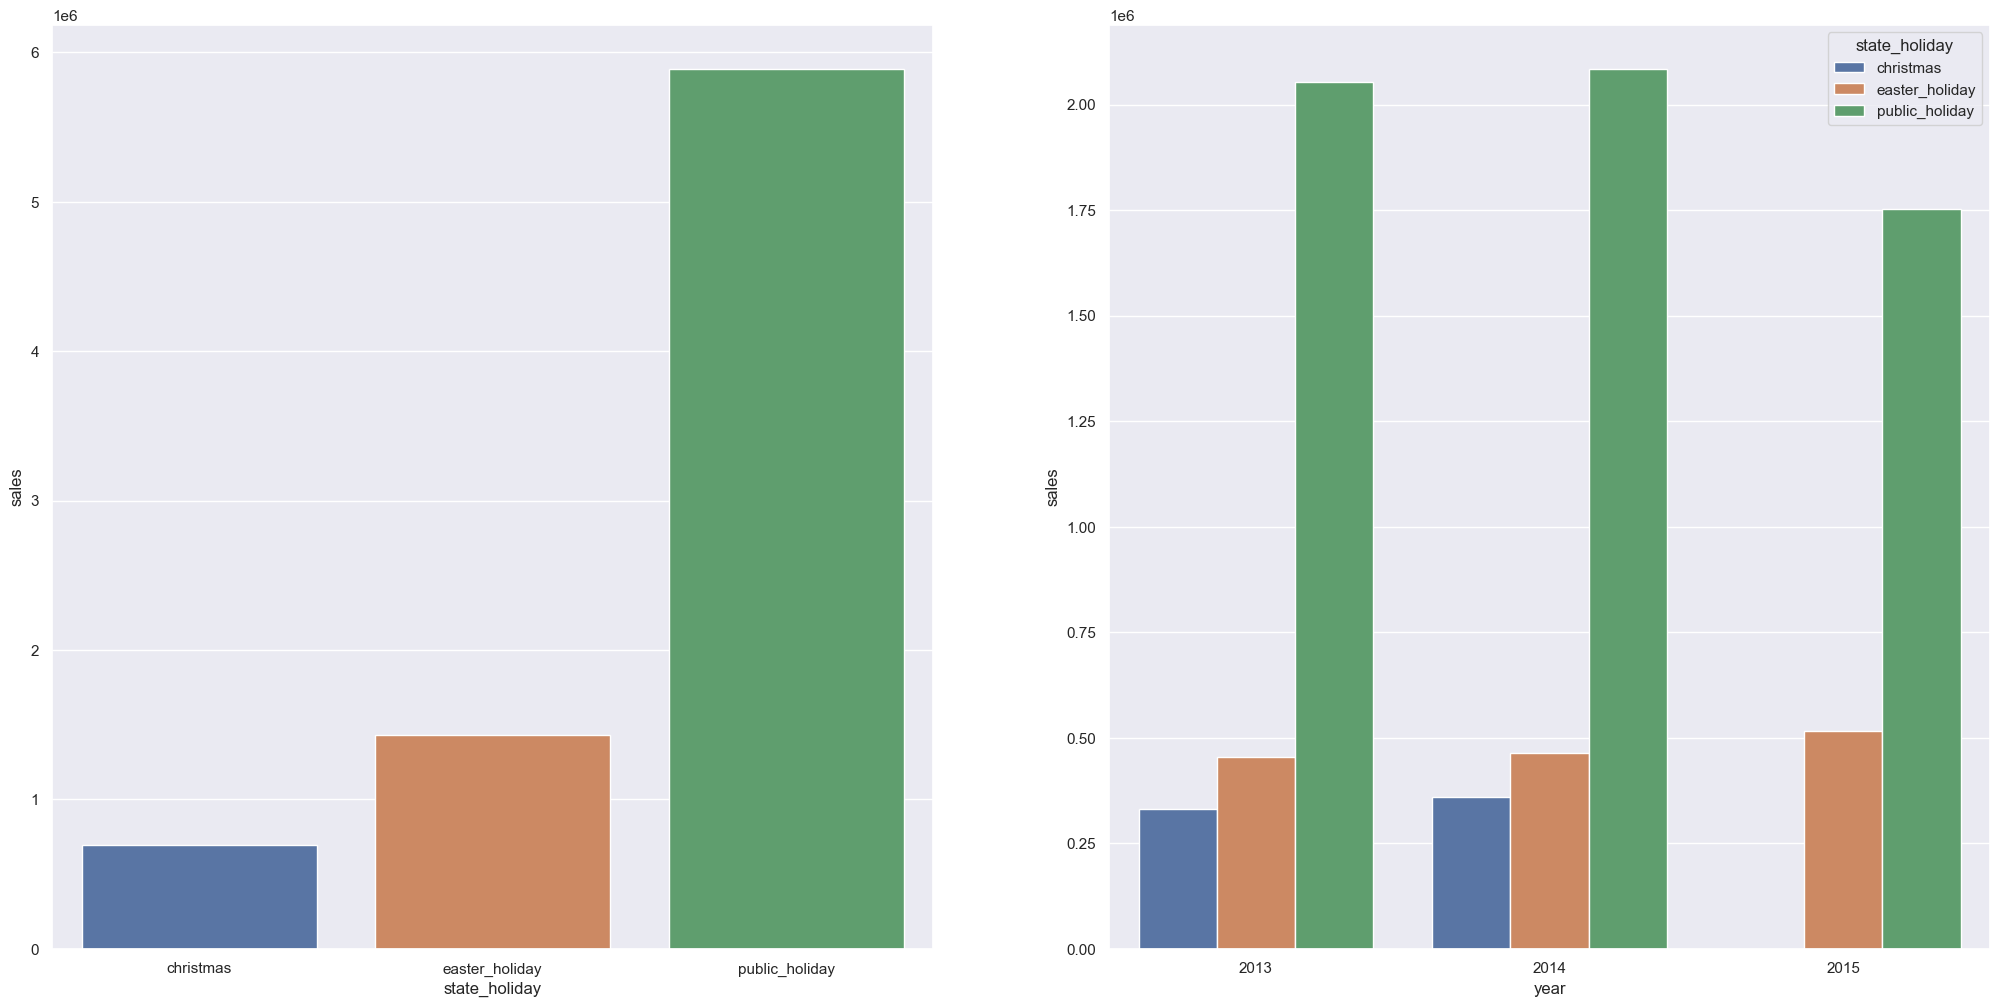

In [41]:
#FALSE
#Remove the regular_day because is the big part of the data
#Analysis: Christmas didn't sell more
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby(['state_holiday']).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);
plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday' ,data=aux2  );

#### H**8.** Stores should sell more over the years.

UFuncTypeError: Cannot cast ufunc 'svd_n_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

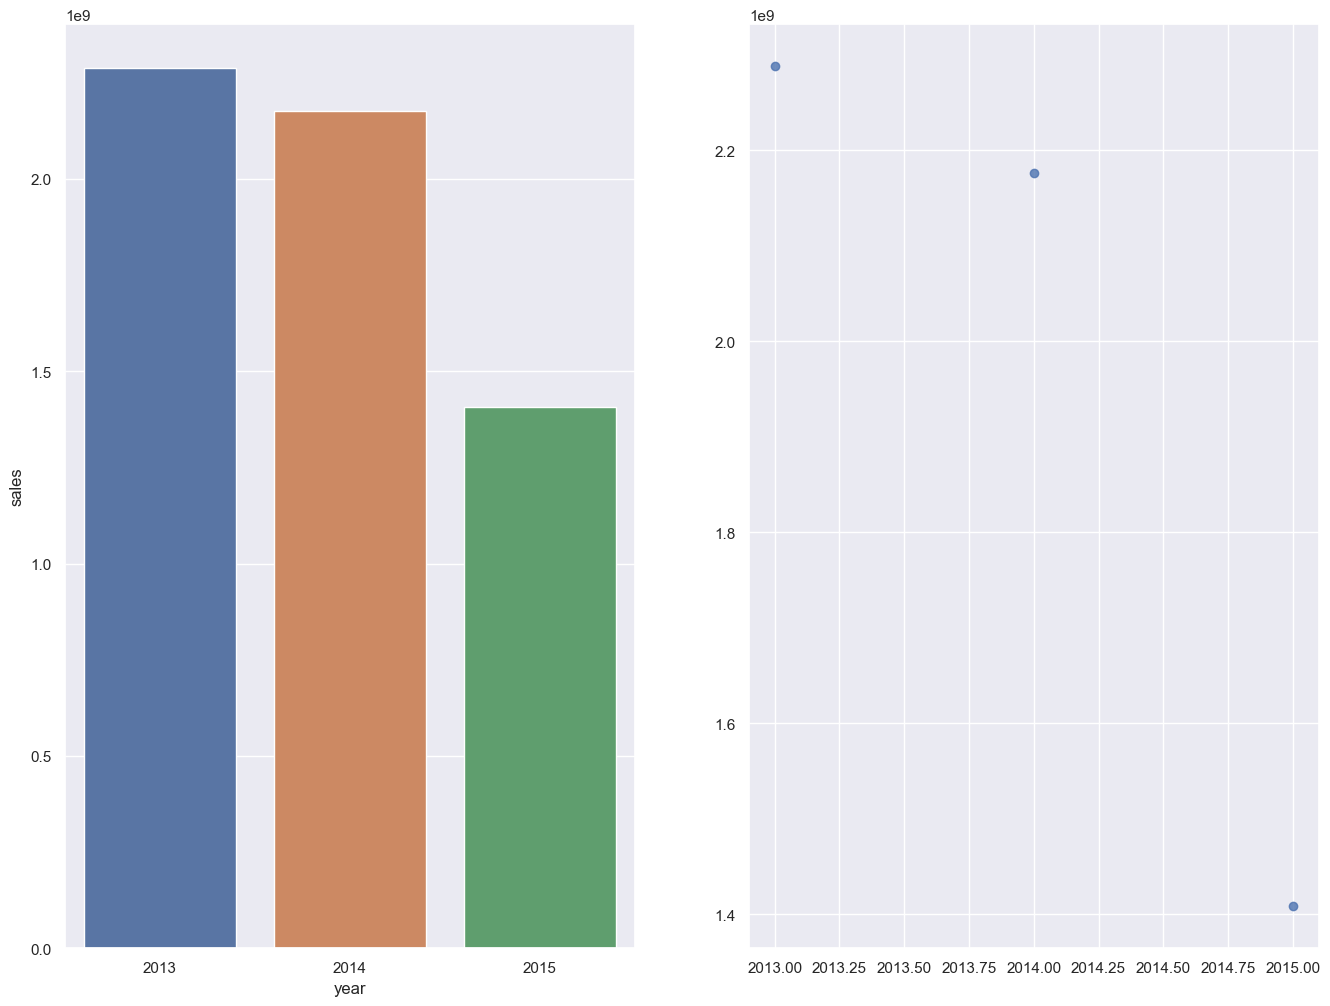

In [42]:
#False
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### H**9.** Stores should sell more o the second half

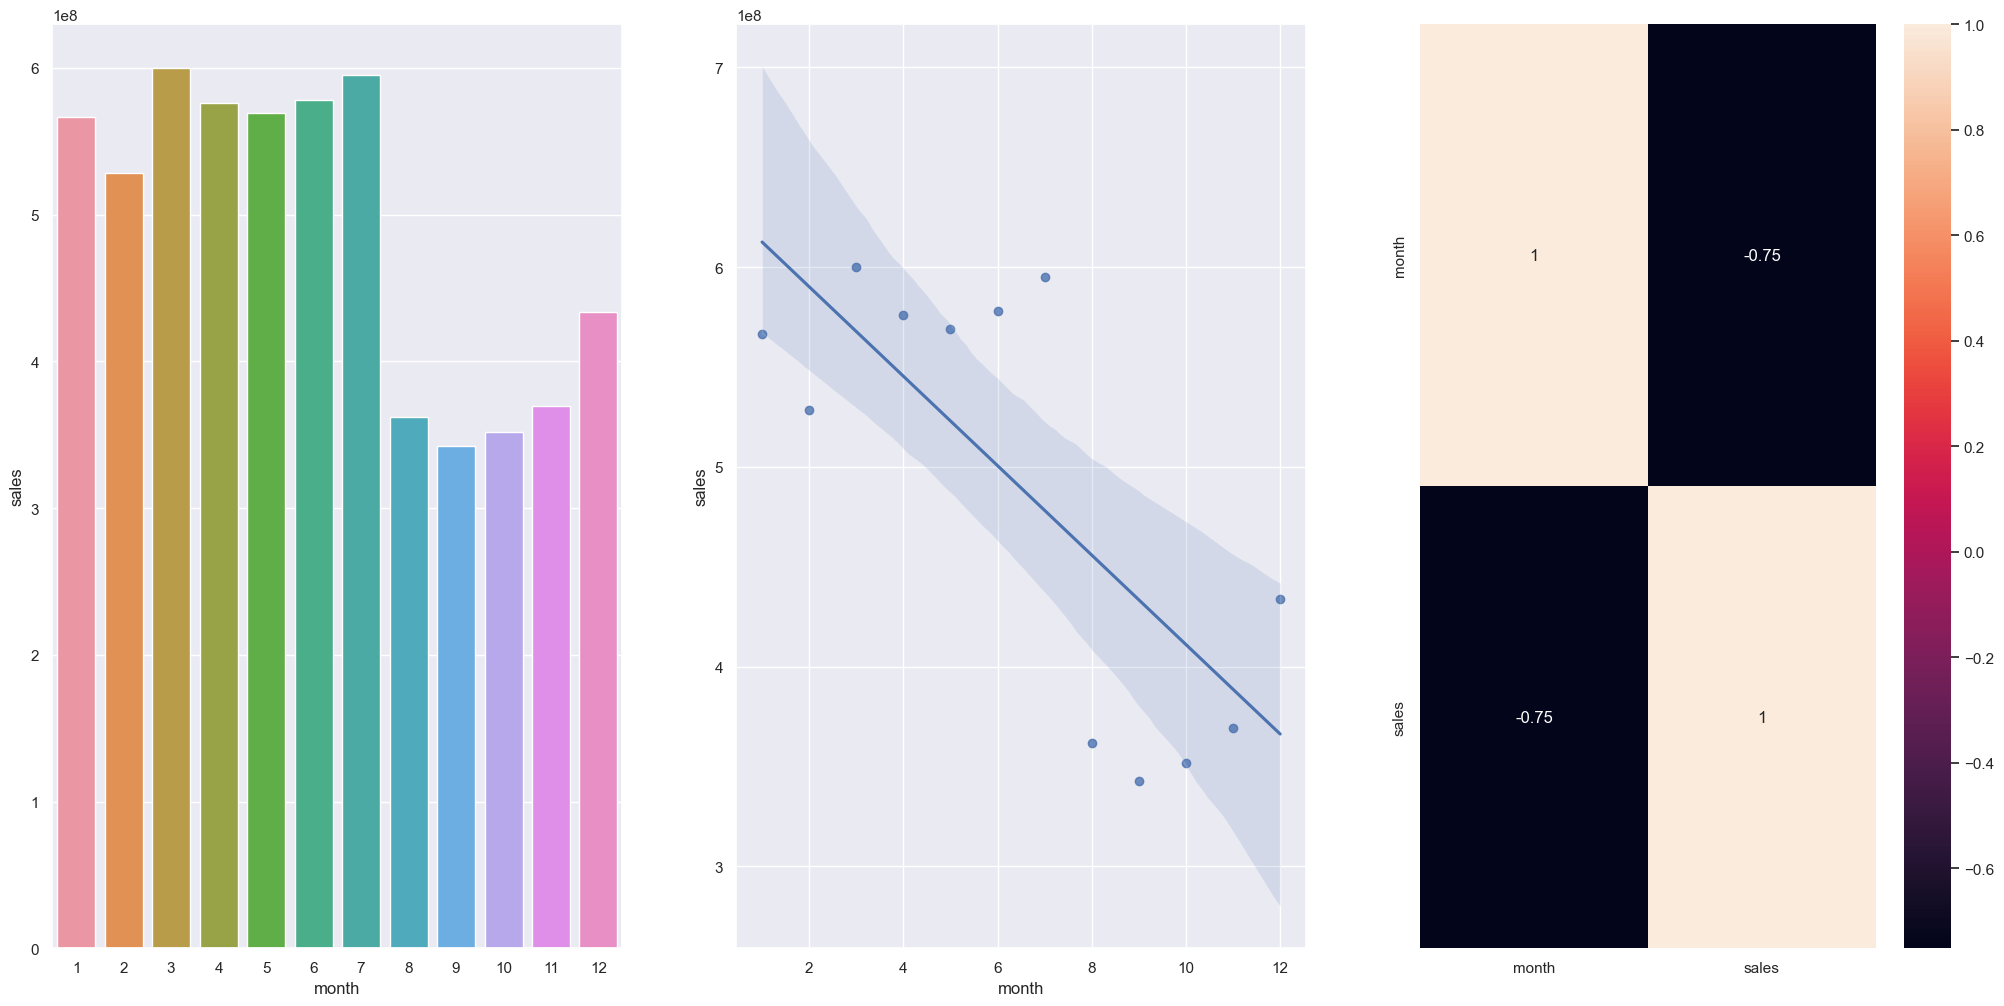

In [43]:
#False
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### H**10.** Stores should sell more after the 10th day of the month.

In [ ]:
#False
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

#### H**11.** Stores should sell less on the weekends.

In [ ]:
#TRUE
#Analysis: 6(Saturday) and 7(Sunday) sell less
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### H**12.** Stores should sell less on the school holidays.

In [ ]:
#FALSE
#Analysis: 0(Normal day) and 1(School Holiday) selling less
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);


### 4.5.3 Multivariate Analisis

#### 4.5.3.1 Numerical Variable

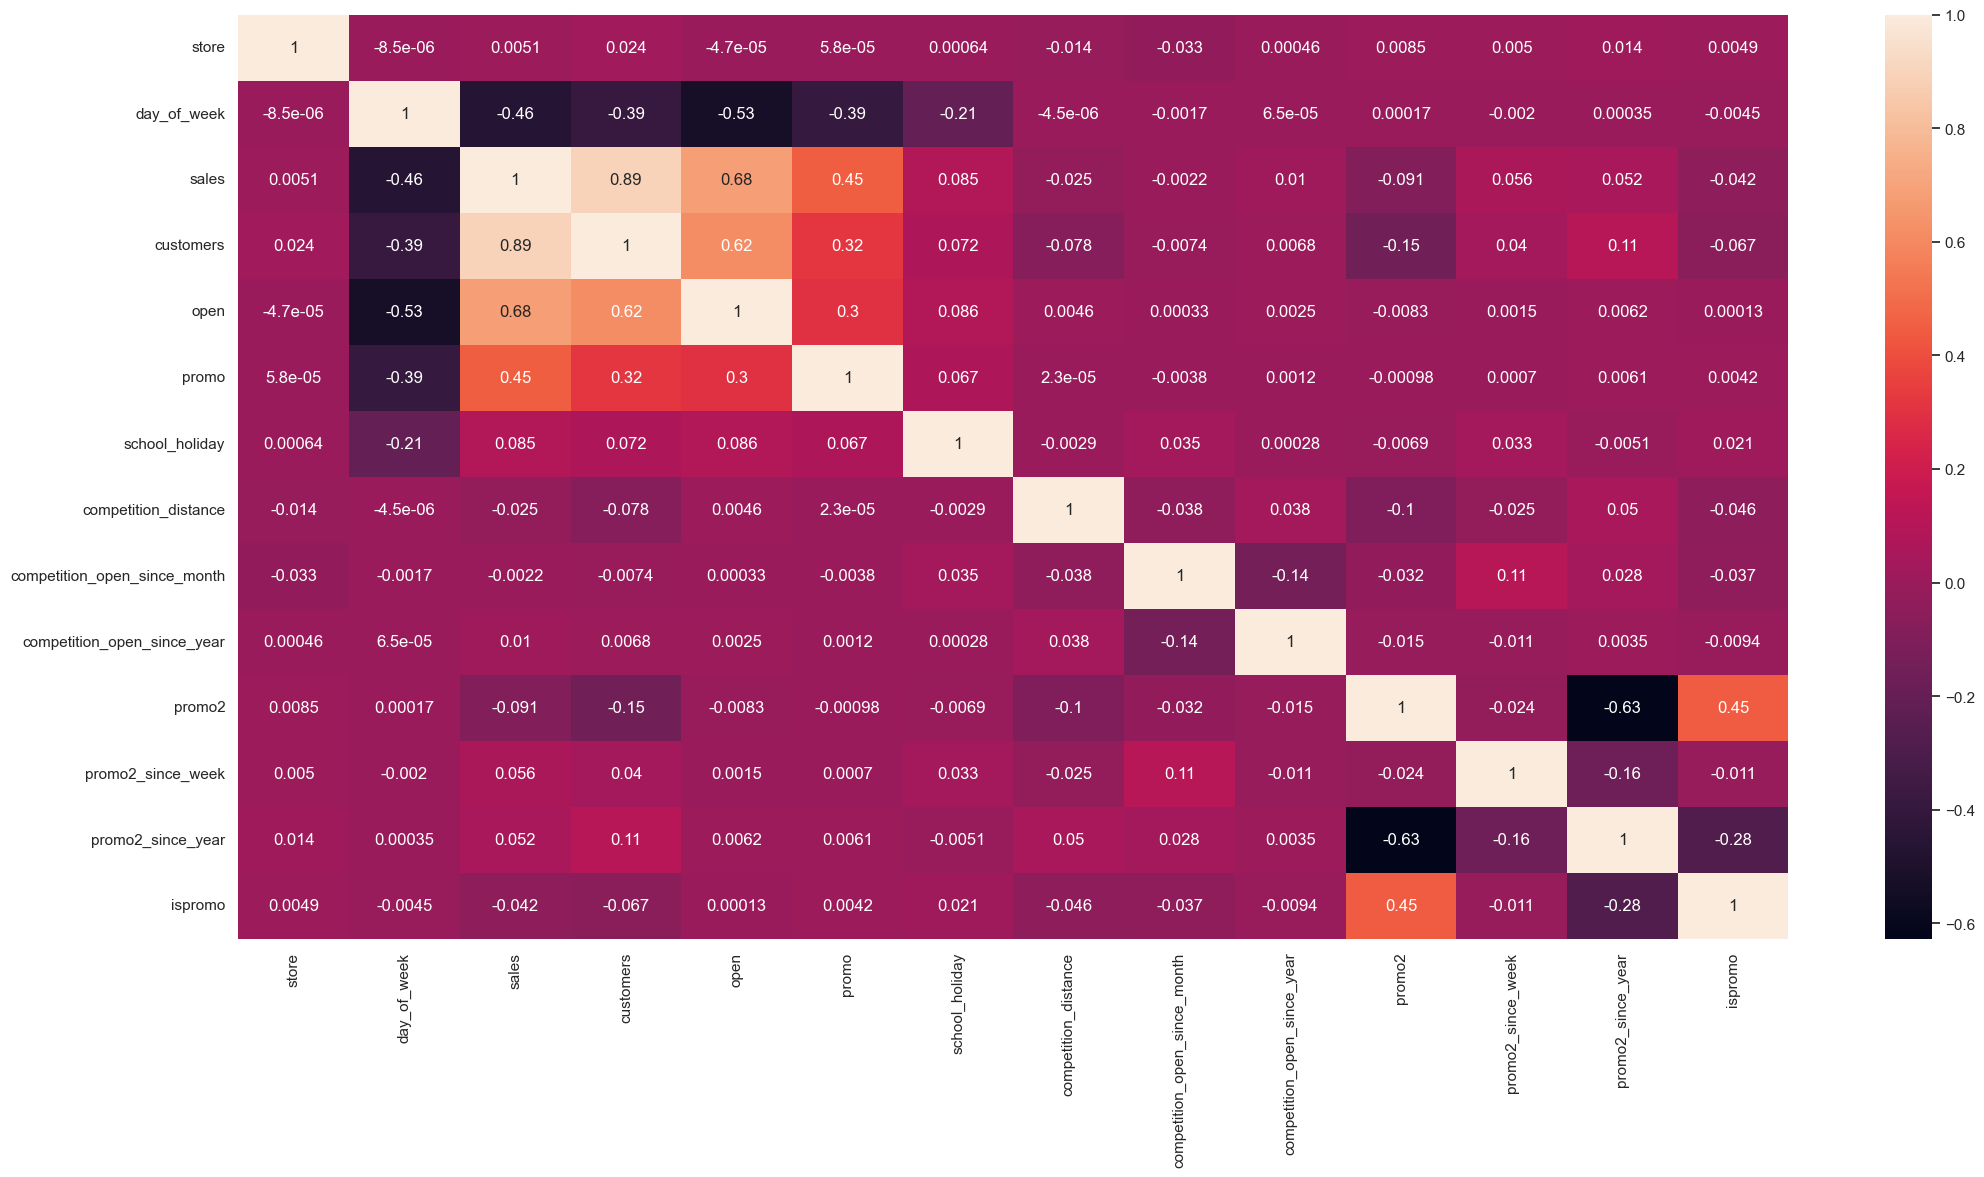

In [44]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

#### 4.5.3.2 Categorical Variable

In [45]:
#pd.crosstab(categorical_variable2['state_holiday'], categorical_variable2['store_type'])

categorical_variable2 = df4[['state_holiday','store_type','assortment']]


a1 = cramer_v( categorical_variable2['state_holiday'],  categorical_variable2['state_holiday']  )
a2 = cramer_v( categorical_variable2['state_holiday'],  categorical_variable2['store_type']  )
a3 = cramer_v( categorical_variable2['state_holiday'],  categorical_variable2['assortment']  )

a4 = cramer_v( categorical_variable2['store_type'],  categorical_variable2['store_type']  )
a5 = cramer_v( categorical_variable2['store_type'],  categorical_variable2['state_holiday']  )
a6 = cramer_v( categorical_variable2['store_type'],  categorical_variable2['assortment']  )

a7 = cramer_v( categorical_variable2['assortment'],  categorical_variable2['assortment']  )
a8 = cramer_v( categorical_variable2['assortment'],  categorical_variable2['state_holiday']  )
a9 = cramer_v( categorical_variable2['assortment'],  categorical_variable2['store_type']  )

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]   })

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

# 5.0 Data Modeling

**IMPORTANT**

<u>**motivation:**</u> The majority of the ML algorithm's learning is facilitated with numerical and on the same scale data.

This step will prepare the data to use on the ML MODEL in 3 types:

1. Normalization 
    - Rescale the center to (Zero) with STD = 1.
2. Rescaling
    - Rescale the interview between 0 and 1
    - Not used on Gaussianas distribuition (no normal distribuition)
3. Transdormation
    - Conversation categorical features to numerical features (ENCODING)
    - Natural transformation (months name to numerical -Jan, Feb, Mar -> 1, 2, 3) have a cicle.

In [46]:
df5 = df4.copy()

## 5.1 Normalization

On the step 4.5.1.2 Numerical Variable we can't see the normal distribuition to use the normalization.

## 5.2 Rescaling

1. Min-Max Scaler (**ATTENTION WITH OUTLIERS**)
 
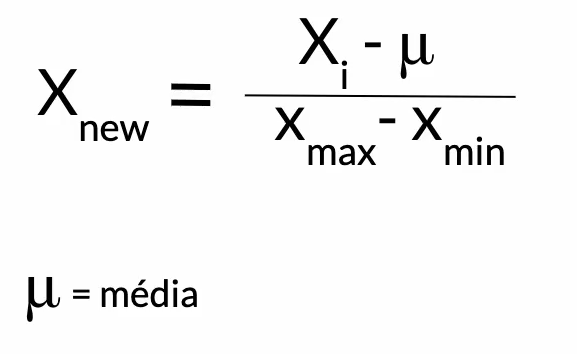

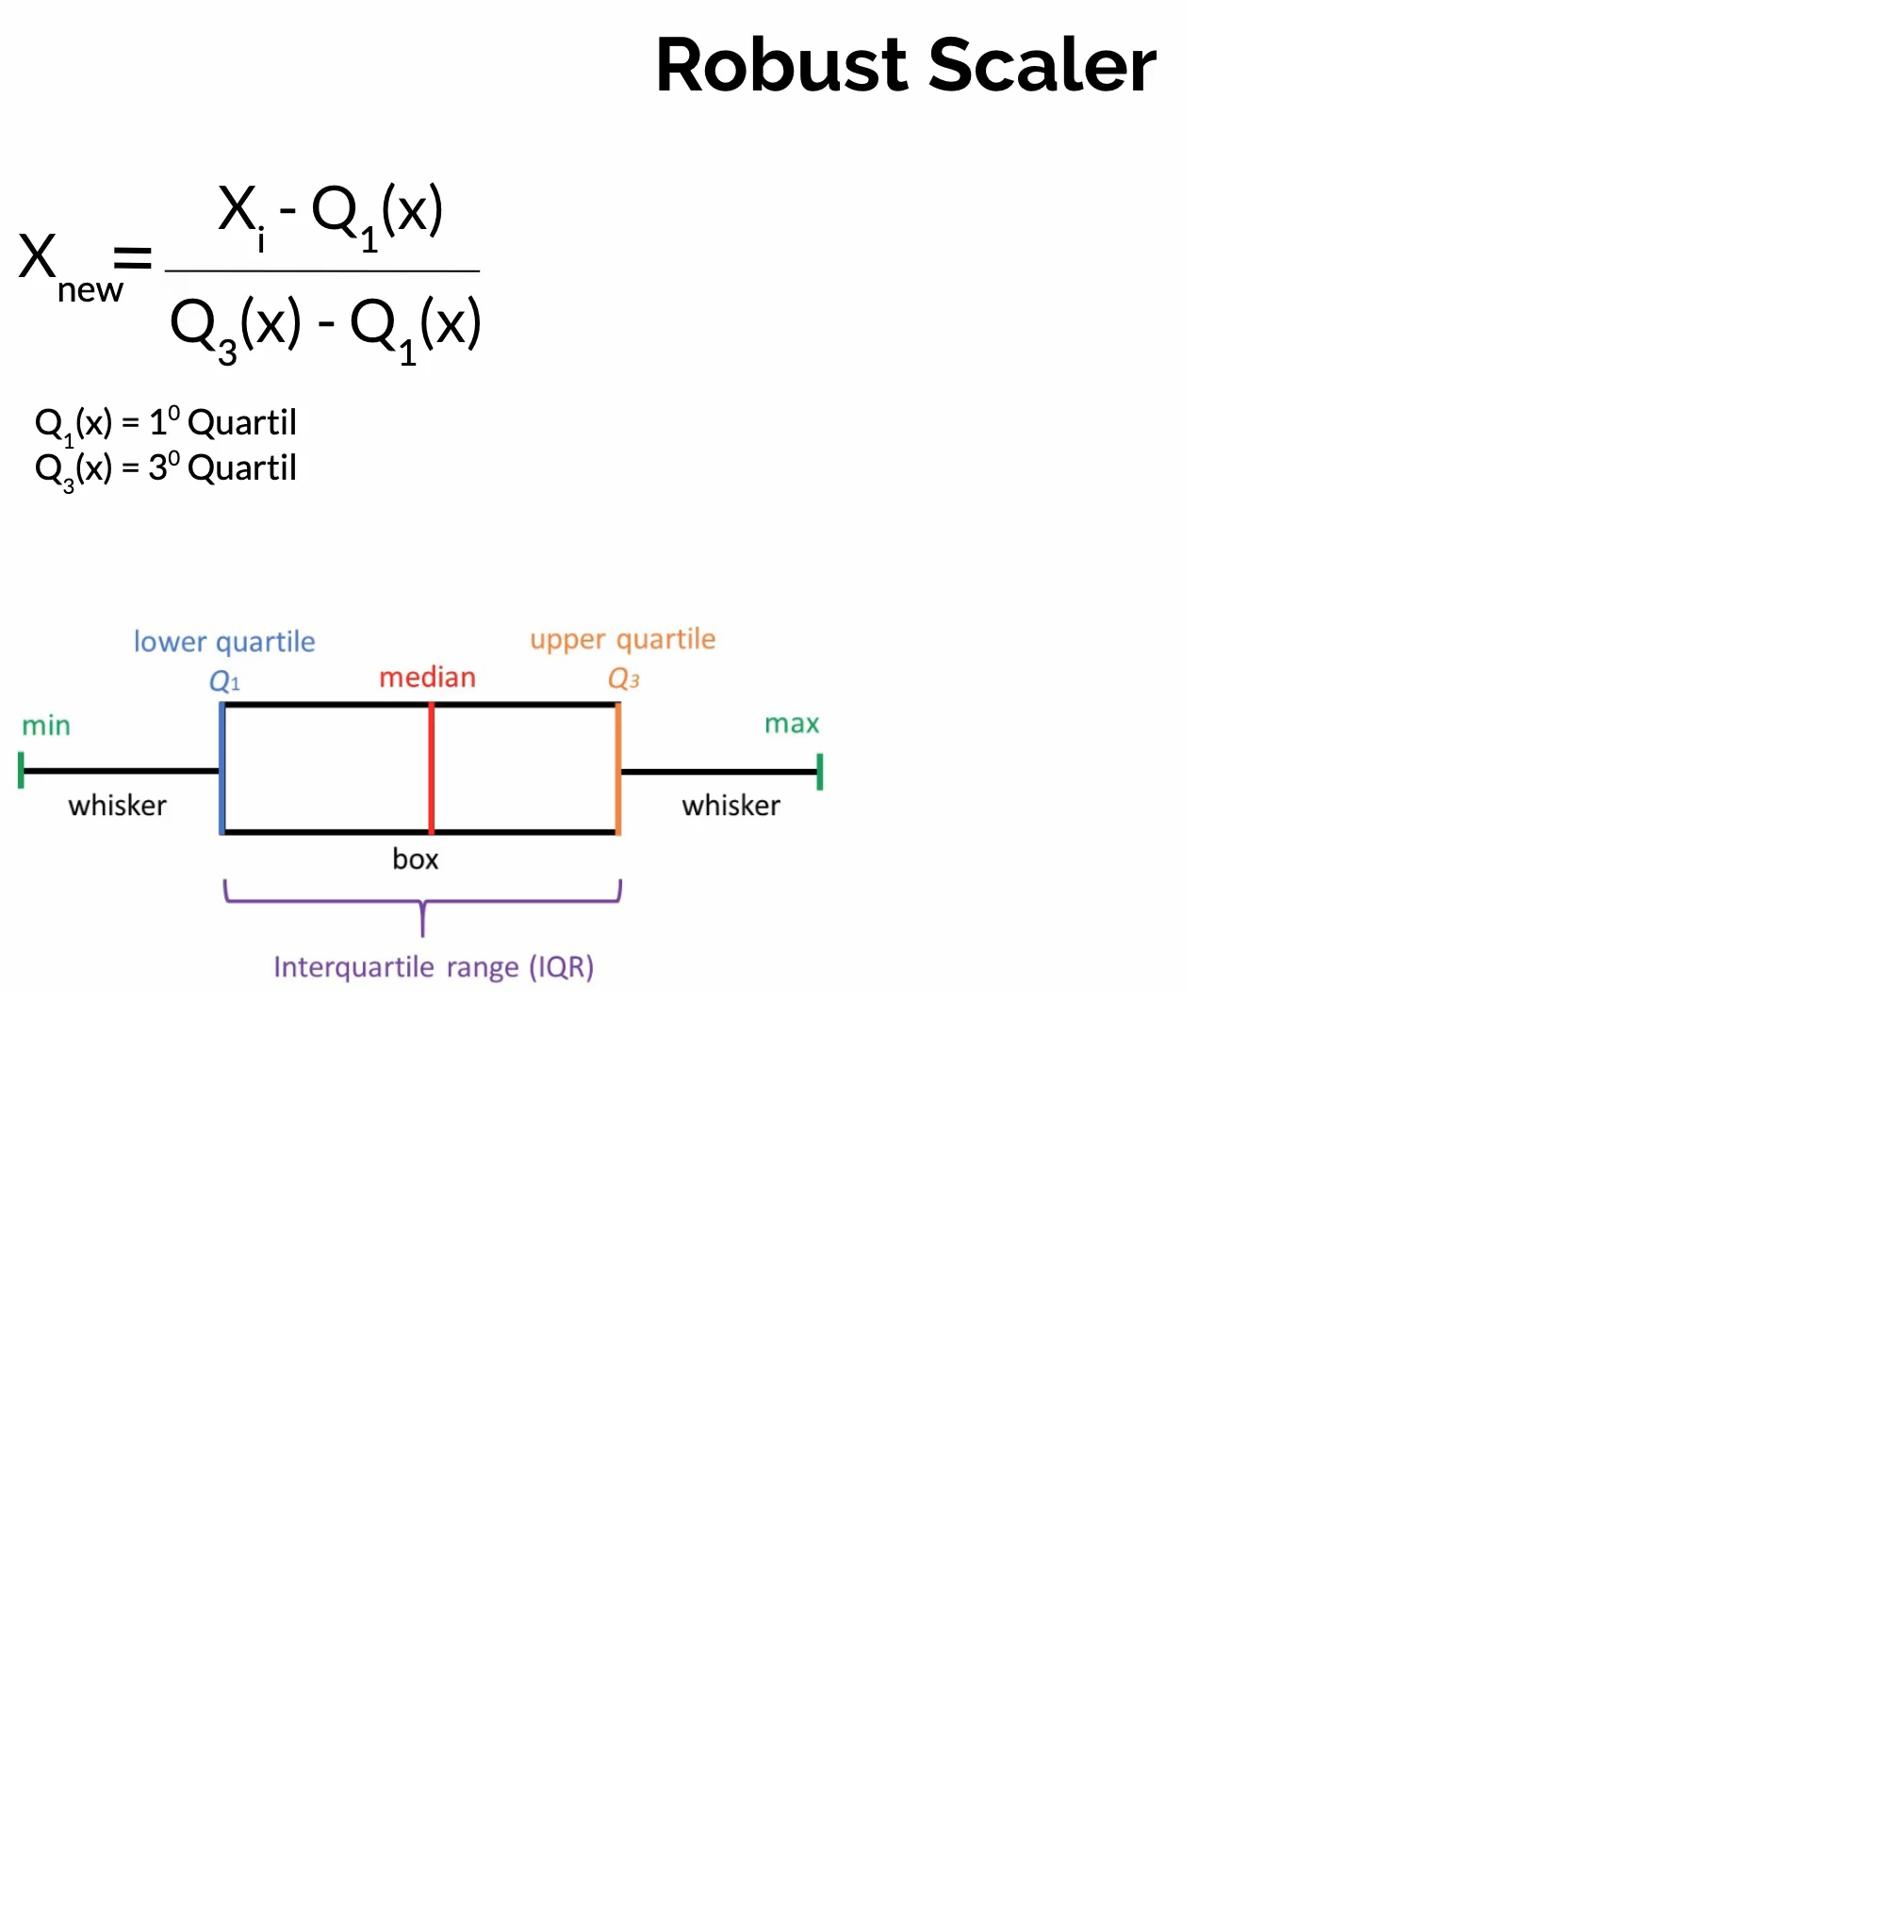

In [52]:
#2. Robust Scaler
Image( '../assets/robustscaler.png' )

In [57]:
#Selecting numerical features
a = df5.select_dtypes( include=['int64','float64'] )

<Axes: >

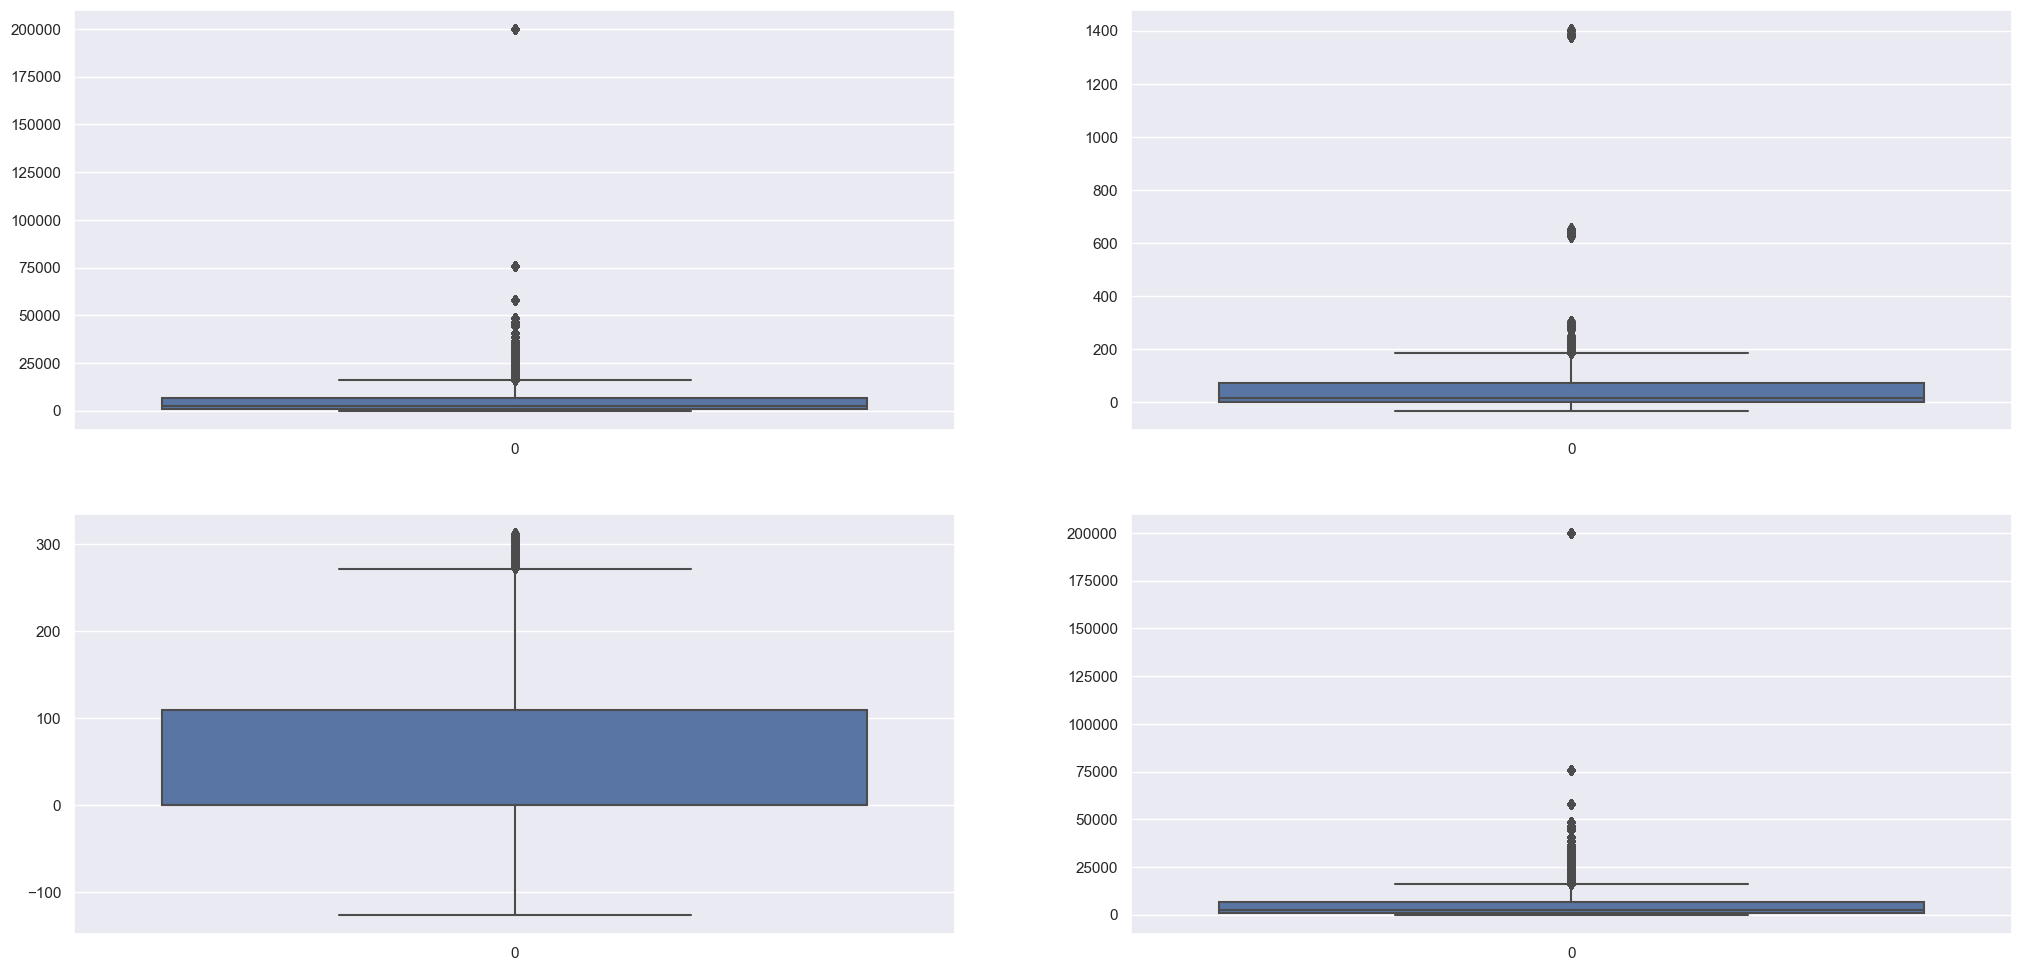

In [64]:
#Checking the outliers to decide the method

#competition_distance
#METHOD - ROBUST SCALER (lot of outliers)
plt.subplot(2,2,1)
sns.boxplot(a['competition_distance'])

#competition_time_month
#METHOD - ROBUST SCALER (lot of outliers)
plt.subplot(2,2,2)
sns.boxplot(a['competition_time_month'])

#promo_time_week
#METHOD - MIN MAX SCALER
plt.subplot(2,2,3)
sns.boxplot(a['promo_time_week'])

#year
#METHOD - MIN MAX SCALER
plt.subplot(2,2,4)
sns.boxplot(a['year'])


In [66]:
#competition_distance
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

#competition_time_month
mms = MinMaxScaler()
df5['promo_time_week'] = rs.fit_transform( df5[['promo_time_week']].values )

df5['year'] = rs.fit_transform( df5[['year']].values )

In [ ]:
#After Rescaling

#competition_distance
#METHOD - ROBUST SCALER (lot of outliers)
plt.subplot(2,2,1)
sns.distplot(a['competition_distance']);

#competition_time_month
#METHOD - ROBUST SCALER (lot of outliers)
plt.subplot(2,2,2)
sns.distplot(a['competition_time_month']);

#promo_time_week
#METHOD - MIN MAX SCALER
plt.subplot(2,2,3)
sns.distplot(a['promo_time_week']);

#year
#METHOD - MIN MAX SCALER
plt.subplot(2,2,4)
sns.distplot(a['year']);

In [ ]:
#day_of_week
#month
#day
#week_of_year
